<a href="https://colab.research.google.com/github/DSRaza403/LAB-Tasks/blob/main/Lab%202/Lab2A_Mohammed_Raza.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Lab 2(A) - EDA Big Data**

###Name: Mohammed Raza Asfak Chidimar

###Matric no.: MCS231004

# Exploratory Data Analysis of 7+ million company dataset

## Objective

* What can we learn about business names?
* How can we use these insights?

## Imports

In [3]:
pip install geotext

In [4]:
pip install -U kaleido

In [5]:
import numpy as np
import pandas as pd
import geopandas as gpd
import geotext
import collections
import string, sys, os, re
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
from IPython.display import Image
from functools import reduce
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [6]:
warnings.filterwarnings('ignore')

## Helper functions and classes

In [7]:
class DfOverview:
    """
        Give an overview for a given data frame,
        like null persentage for each columns,
        unique value percentage for each columns and more
    """

    def __init__(self, df: pd.DataFrame) -> None:
        self.df = df

    def missing_value(self) -> None:
        nullSum = self.df.isna().sum()
        return [col for col in nullSum]

    def percentage(self, list):
        return [str(round(((value / self.df.shape[0]) * 100), 2)) + '%' for value in list]

    def getOverview(self) -> None:

        _columns = [column for column in self.df]
        _count = self.df.count().values
        _unique = [self.df[column].value_counts().shape[0] for column in self.df]
        _missing_values = self.missing_value()

        columns = [
            'Column',
            'count',
            'missing_value_count',
            'Missing_value_percentage',
            'unique_value_count',
            'unique_value_percentage',
            'dtype']
        data = zip(
            _columns,
            _count,
            _missing_values,
            self.percentage(_missing_values),
            _unique,
            self.percentage(_unique),
            self.df.dtypes
        )
        new_df = pd.DataFrame(data=data, columns=columns)
        return new_df

In [8]:
def show_cols_mixed_dtypes(df):
    mixed_dtypes = {'Column': [], 'Data type': []}
    for col in df.columns:
        dtype = pd.api.types.infer_dtype(df[col])
        if dtype.startswith("mixed"):
            mixed_dtypes['Column'].append(col)
            mixed_dtypes['Data type'].append(dtype)
    if len(mixed_dtypes['Column']) == 0:
        print('None of the columns contain mixed types.')
    else:
        print(pd.DataFrame(mixed_dtypes))

In [9]:
def percent_missing_values(df):

    # Calculate total number of cells in dataframe
    totalCells = np.product(df.shape)

    # Count number of missing values per column
    missingCount = df.isnull().sum()

    # Calculate total number of missing values
    totalMissing = missingCount.sum()

    # Calculate percentage of missing values
    print("The dataset contains", round(((totalMissing/totalCells) * 100), 2), "%", "missing values.")

In [10]:
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * mis_val / len(df)

    # dtype of missing values
    mis_val_dtype = df.dtypes

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent, mis_val_dtype], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values', 2: 'Dtype'})

    # Sort the table by percentage of missing descending and remove columns with no missing values
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,0] != 0].sort_values(
    '% of Total Values', ascending=False).round(2)

    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    if mis_val_table_ren_columns.shape[0] == 0:
        return

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [11]:
def convert_to_string(df, columns):
    for col in columns:
        df[col] = df[col].astype("string")

In [12]:
def drop_duplicates(df):
    old = df.shape[0]
    df.drop_duplicates(inplace=True)
    new = df.shape[0]
    count = old - new
    if (count == 0):
        print("No duplicate rows were found.")
    else:
        print(f"{count} duplicate rows were found and removed.")

def plot_dist(df:pd.DataFrame, column:str, color:str='cornflowerblue')->None:
    sns.displot(data=df, x=column, color=color,  kde=False, height=6, aspect=2)
    plt.title(f'Distribution of {column}', size=20, fontweight='bold')
    plt.show()

def plotly_plot_bar(df, x, y, title=None, width=800, color=['cornflowerblue']):
    if title == None:
        title=f'Distribution of {x}'
    fig = px.bar(df, x=x, y=y, title=title)
    return Image(pio.to_image(fig, format='png', width=width))

def plotly_plot_pie(df, column, title=None, width=800, limit=None):
    a = pd.DataFrame({'count': df.groupby([column]).size()}).reset_index()
    a = a.sort_values("count", ascending=False)
    if limit:
        a.loc[a['count'] < limit, column] = f'Other {column}s'
    if title == None:
        title=f'Distribution of {column}'
    fig = px.pie(a, values='count', names=column, title=title)
    return Image(pio.to_image(fig, format='png', width=width))

## Data Reading

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
! pip install kaggle
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [15]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

In [16]:
! kaggle datasets download -d peopledatalabssf/free-7-million-company-dataset
! unzip free-7-million-company-dataset

free-7-million-company-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  free-7-million-company-dataset.zip
replace companies_sorted.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [17]:
# reading the companies_sorted csv file
df = pd.read_csv("/content/companies_sorted.csv")
df

Unnamed: 0                            name  \
0           5872184                             ibm   
1           4425416       tata consultancy services   
2             21074                       accenture   
3           2309813                         us army   
4           1558607                              ey   
...             ...                             ...   
7173421     1494427              certiport vouchers   
7173422     1494429          black tiger fight club   
7173423     4768462      catholic bishop of chicago   
7173424     1494436             medexo robotics ltd   
7173425     2842728  dynamic controls solutions inc   

                               domain  year founded  \
0                             ibm.com        1911.0   
1                             tcs.com        1968.0   
2                       accenture.com        1989.0   
3                          goarmy.com        1800.0   
4                              ey.com        1989.0   
...                               ...           ...   
7173421         certiportvouchers.com        2011.0   
7173422            blacktigerclub.com        2006.0   
7173423                           NaN           NaN   
7173424                           NaN           NaN   
7173425  dynamiccontrolssolutions.com           NaN   

                                    industry size range  \
0        information technology and services     10001+   
1        information technology and services     10001+   
2        information technology and services     10001+   
3                                   military     10001+   
4                                 accounting     10001+   
...                                      ...        ...   
7173421  information technology and services     1 - 10   
7173422         health, wellness and fitness     1 - 10   
7173423               religious institutions     1 - 10   
7173424                             research     1 - 10   
7173425                           automotive     1 - 10   

                                       locality         country  \
0             new york, new york, united states   united states   
1                    bombay, maharashtra, india           india   
2                       dublin, dublin, ireland         ireland   
3           alexandria, virginia, united states   united states   
4        london, greater london, united kingdom  united kingdom   
...                                         ...             ...   
7173421                                     NaN             NaN   
7173422                  peking, beijing, china           china   
7173423      inverness, illinois, united states   united states   
7173424          london, london, united kingdom  united kingdom   
7173425          wixom, michigan, united states   united states   

                                              linkedin url  \
0                                 linkedin.com/company/ibm   
1           linkedin.com/company/tata-consultancy-services   
2                           linkedin.com/company/accenture   
3                             linkedin.com/company/us-army   
4                       linkedin.com/company/ernstandyoung   
...                                                    ...   
7173421            linkedin.com/company/certiport-vouchers   
7173422         linkedin.com/company/black-tiger-club-hero   
7173423    linkedin.com/company/catholic-bishop-of-chicago   
7173424           linkedin.com/company/medexo-robotics-ltd   
7173425  linkedin.com/company/dynamic-controls-solution...   

         current employee estimate  total employee estimate  
0                           274047                   716906  
1                           190771                   341369  
2                           190689                   455768  
3                           162163                   445958  
4                           158363                   428960  
...                            ...                      

## General Statistics

In [18]:
# number of elements(cells) in the df
df.size

78907686

In [19]:
# rows and columns in the df
df.shape

(7173426, 11)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7173426 entries, 0 to 7173425
Data columns (total 11 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   Unnamed: 0                 int64  
 1   name                       object 
 2   domain                     object 
 3   year founded               float64
 4   industry                   object 
 5   size range                 object 
 6   locality                   object 
 7   country                    object 
 8   linkedin url               object 
 9   current employee estimate  int64  
 10  total employee estimate    int64  
dtypes: float64(1), int64(3), object(7)
memory usage: 602.0+ MB


In [21]:
df_overview = DfOverview(df)
df_overview.getOverview()

Column    count  missing_value_count  \
0                  Unnamed: 0  7173426                    0   
1                        name  7173423                    3   
2                      domain  5522805              1650621   
3                year founded  3566446              3606980   
4                    industry  6883423               290003   
5                  size range  7173426                    0   
6                    locality  4664601              2508825   
7                     country  4824219              2349207   
8                linkedin url  7173426                    0   
9   current employee estimate  7173426                    0   
10    total employee estimate  7173426                    0   

   Missing_value_percentage  unique_value_count unique_value_percentage  \
0                      0.0%             7173426                  100.0%   
1                      0.0%             7004634                  97.65%   
2                    23.01%             5474764                  76.32%   
3                    50.28%                 234                    0.0%   
4                     4.04%                 148                    0.0%   
5                      0.0%                   8                    0.0%   
6                    34.97%               96244                   1.34%   
7                    32.75%                 236                    0.0%   
8                      0.0%             7173426                  100.0%   
9                      0.0%                5379                   0.07%   
10                     0.0%                8486                   0.12%   

      dtype  
0     int64  
1    object  
2    object  
3   float64  
4    object  
5    object  
6    object  
7    object  
8    object  
9     int64  
10    int64

Here we can see detailed informations of the columns including the amount missing and unique values.

## Dropping unnecessary Columns

The column 'Unamed: 0' most of the times represents the index when we save our dataframe to csv along with our index. In this is the case, since each index is unique and not actually related to each row, removing it is advisable. Let us check its uniqueness.

In [22]:
# comparing the number of unique values of 'Unnamed: 0' and the number of rows
len(df['Unnamed: 0'].unique()) == df.shape[0]

True

Since my assumption is correct, I will remove the column.

In [23]:
df.drop(columns=['Unnamed: 0'], inplace=True)

## Missing Values

In [24]:
percent_missing_values(df)

The dataset contains 14.51 % missing values.


In [25]:
missing_values_table(df)

Your selected dataframe has 10 columns.
There are 6 columns that have missing values.


Missing Values  % of Total Values    Dtype
year founded         3606980              50.28  float64
locality             2508825              34.97   object
country              2349207              32.75   object
domain               1650621              23.01   object
industry              290003               4.04   object
name                       3               0.00   object

From the missing table we can see that there are 6 columns with missing values. But name and industry are very necessary. So we will remove rows with null values in these columns.

In [26]:
df.drop(df.index[df.name.isna()], inplace=True)
df.drop(df.index[df.industry.isna()], inplace=True)

In [27]:
missing_values_table(df)

Your selected dataframe has 10 columns.
There are 4 columns that have missing values.


Missing Values  % of Total Values    Dtype
year founded         3317945              48.20  float64
locality             2304053              33.47   object
country              2148684              31.22   object
domain               1473392              21.40   object

## Data Types

Let's check if there are columns with mixed data types.

In [28]:
show_cols_mixed_dtypes(df)

None of the columns contain mixed types.


In [29]:
df.dtypes

name                          object
domain                        object
year founded                 float64
industry                      object
size range                    object
locality                      object
country                       object
linkedin url                  object
current employee estimate      int64
total employee estimate        int64
dtype: object

In [30]:
df.head()

name         domain  year founded  \
0                        ibm        ibm.com        1911.0   
1  tata consultancy services        tcs.com        1968.0   
2                  accenture  accenture.com        1989.0   
3                    us army     goarmy.com        1800.0   
4                         ey         ey.com        1989.0   

                              industry size range  \
0  information technology and services     10001+   
1  information technology and services     10001+   
2  information technology and services     10001+   
3                             military     10001+   
4                           accounting     10001+   

                                 locality         country  \
0       new york, new york, united states   united states   
1              bombay, maharashtra, india           india   
2                 dublin, dublin, ireland         ireland   
3     alexandria, virginia, united states   united states   
4  london, greater london, united kingdom  united kingdom   

                                     linkedin url  current employee estimate  \
0                        linkedin.com/company/ibm                     274047   
1  linkedin.com/company/tata-consultancy-services                     190771   
2                  linkedin.com/company/accenture                     190689   
3                    linkedin.com/company/us-army                     162163   
4              linkedin.com/company/ernstandyoung                     158363   

   total employee estimate  
0                   716906  
1                   341369  
2                   455768  
3                   445958  
4                   428960

As we can see from above 'name', 'domain', 'industry', 'size range', 'locality', 'country' and 'linkedin url' hold string values. In addition to this we also know that 'year founded' should hold integer values. Therefore, we will convert these columns to their respective correct data types.

In [31]:
# get the columns with object data type
string_columns = df.select_dtypes(include='object').columns.tolist()
string_columns

['name',
 'domain',
 'industry',
 'size range',
 'locality',
 'country',
 'linkedin url']

In [32]:
convert_to_string(df, string_columns)

In order to convert 'year founded', we have to replace NaN values with 0 so that pandas will not raise an error saying "Cannot convert non-finite values (NA or inf) to integer".

In [33]:
df['year founded'].fillna(0, inplace=True)
df['year founded'] = df['year founded'].astype('int64')

In [34]:
df.dtypes

name                         string
domain                       string
year founded                  int64
industry                     string
size range                   string
locality                     string
country                      string
linkedin url                 string
current employee estimate     int64
total employee estimate       int64
dtype: object

In [35]:
df.head()

name         domain  year founded  \
0                        ibm        ibm.com          1911   
1  tata consultancy services        tcs.com          1968   
2                  accenture  accenture.com          1989   
3                    us army     goarmy.com          1800   
4                         ey         ey.com          1989   

                              industry size range  \
0  information technology and services     10001+   
1  information technology and services     10001+   
2  information technology and services     10001+   
3                             military     10001+   
4                           accounting     10001+   

                                 locality         country  \
0       new york, new york, united states   united states   
1              bombay, maharashtra, india           india   
2                 dublin, dublin, ireland         ireland   
3     alexandria, virginia, united states   united states   
4  london, greater london, united kingdom  united kingdom   

                                     linkedin url  current employee estimate  \
0                        linkedin.com/company/ibm                     274047   
1  linkedin.com/company/tata-consultancy-services                     190771   
2                  linkedin.com/company/accenture                     190689   
3                    linkedin.com/company/us-army                     162163   
4              linkedin.com/company/ernstandyoung                     158363   

   total employee estimate  
0                   716906  
1                   341369  
2                   455768  
3                   445958  
4                   428960

Now every data type looks good.

## Duplicates

In [36]:
# search for duplicate rows and drop them
drop_duplicates(df)

No duplicate rows were found.


Since name is the feature that uniquely identifies each record(company)record, there should be no duplicates. Let's check that.

In [37]:
df.duplicated(subset=['name']).all()

False

We are safe. No two rows in our dataset contain the same name value.

## Univariate Analysis

Here we will analyze each variable. Let us start by checking the statistics of numeric variables.

In [38]:
df.describe().transpose()

count         mean          std  min  25%  \
year founded               6883420.0  1036.865407  1000.340191  0.0  0.0   
current employee estimate  6883420.0    14.448108   361.973117  0.0  1.0   
total employee estimate    6883420.0    33.547708   892.356855  1.0  1.0   

                              50%     75%       max  
year founded               1952.0  2009.0    2103.0  
current employee estimate     1.0     4.0  274047.0  
total employee estimate       2.0     8.0  716906.0

Here we can see some wierd results.
* the maximum value for 'year founded' is 2103.
* the minimum value for 'current employee estimate' is 0.

We will check these in detail when we analyze each column.

### Name

In [39]:
# unique value counts
counts_df = df['name'].value_counts().rename_axis('name').reset_index(name='count')
counts_df

name  count
0                independent consultant     63
1                      private practice     53
2                            consultant     53
3                           independent     49
4                independent contractor     40
...                                 ...    ...
6728512                    pegasus gold      1
6728513       landmark enterprise group      1
6728514                     hotel trail      1
6728515                          amplii      1
6728516  dynamic controls solutions inc      1

[6728517 rows x 2 columns]

Even though pandas.DataFrame.duplicated haven't identified any duplicated names, we have discovered there are some using value_counts. Let's investigate these names.

In [40]:
repeated_names = counts_df[counts_df['count'] > 1].name.to_list()

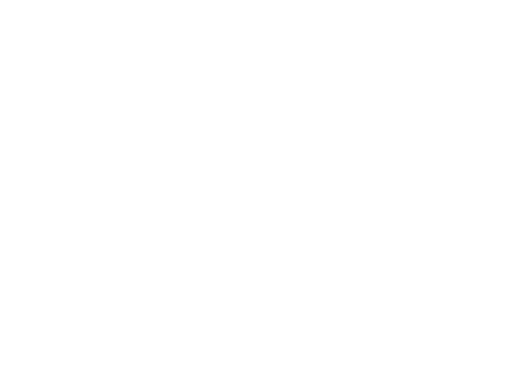

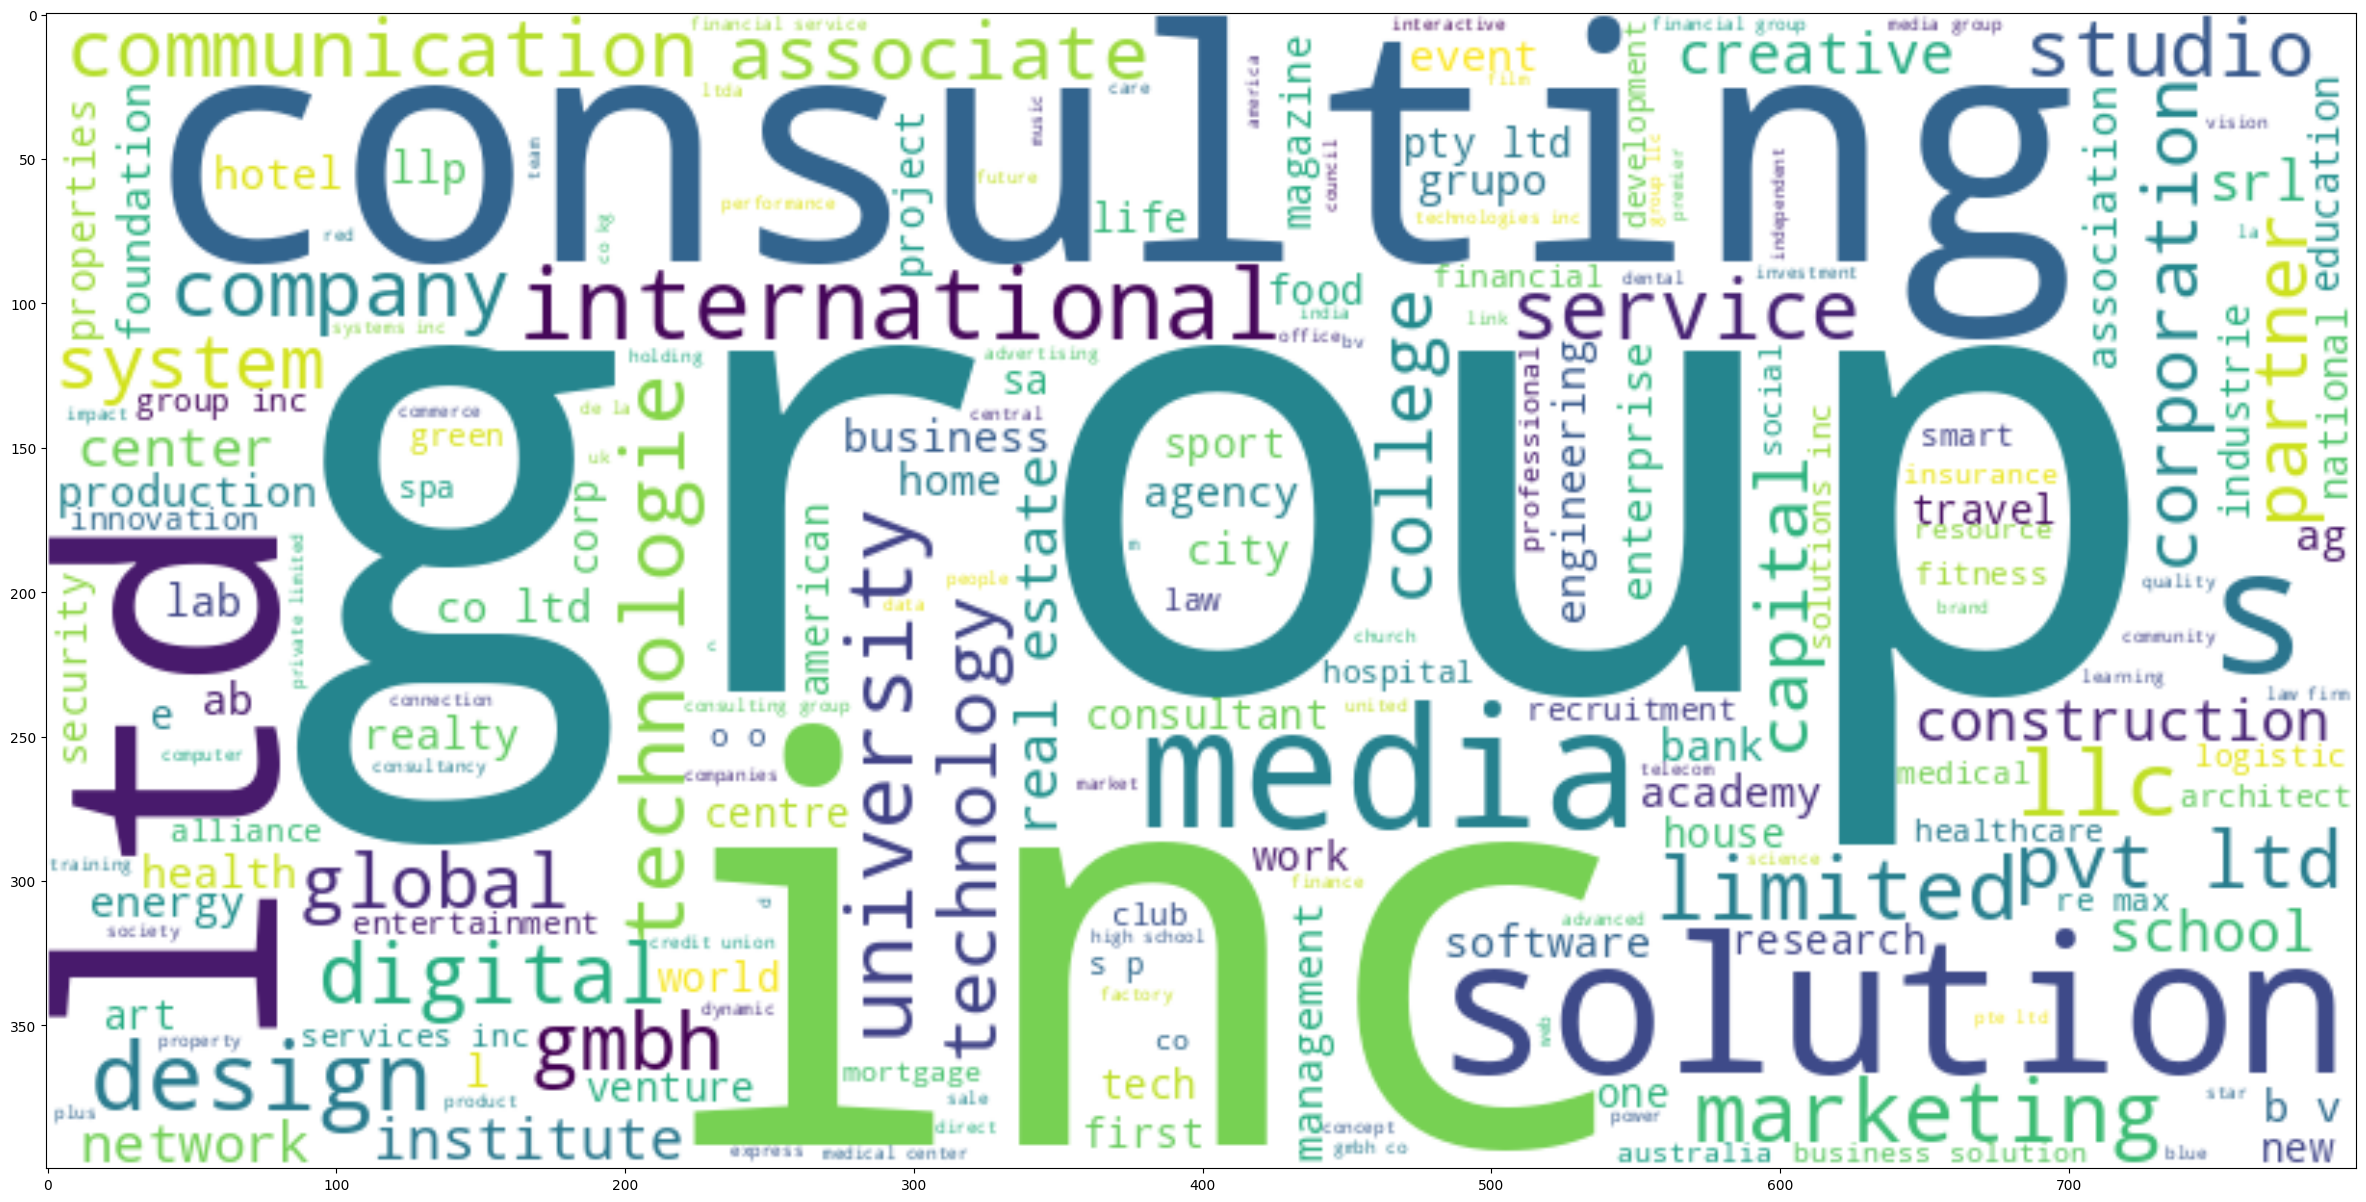

In [41]:
text = " ".join(name for name in df[df.name.isin(repeated_names)].name)

# generate a word cloud image
wordcloud = WordCloud(background_color="white", width=800, height=400).generate(text)

# display the word cloud
plt.axis("off")
plt.figure(figsize=(30,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

The most frequent words in these repeating company names are common words like group, inc, consulting and solution. Having companines with the exact same name in our dataset will conflict with our objective of extracting insights from business names since the values in the other columns differ. So I will remove the companies with their names repeated.

In [42]:
df = df[~df.name.isin(repeated_names)]

Let us examine if there are names containing different kinds of characters other than the english alphabets and space.

In [43]:
# filtering names with a character that is not an english alphabet or space
regexp = re.compile(r'[^a-zA-Z\s]')
df[df.name.apply(lambda x: regexp.search(x)).astype('bool')].name

9                                        at&t
17                       jpmorgan chase & co.
30                     mcdonald's corporation
57           ayatama energi, trisco nusantara
70            secretaría de educación pública
                          ...                
7173397        stone center for yoga & health
7173402                        woonartikel.nl
7173404                     squad sp. z o. o.
7173411    fuller, hadeed, & ros-planas, pllc
7173416                       fit plus s.r.o.
Name: name, Length: 2069320, dtype: string

In [44]:
# filtering names with non-aschii characters, here I considered on the standard aschii characters
regexp = re.compile(r'[^\x00-\x7f]')
df[df.name.apply(lambda x: regexp.search(x)).astype('bool')].name

70                           secretaría de educación pública
81                               verbum traducción y edición
93                                                   l'oréal
168                                   mondelēz international
208                                            itaú unibanco
                                 ...                        
7173288                          uab „plius“ filiāle latvija
7173295           efenex - eficiencia energética extremadura
7173307                                      stora sjöfallet
7173316    versorgungs- und verkehrsgesellschaft saarbrüc...
7173334                iglesia presbiteriana príncipe de paz
Name: name, Length: 286532, dtype: string

In [45]:
# filtering names with digits
regexp = re.compile(r'[0-9]')
df[df.name.apply(lambda x: regexp.search(x)).astype('bool')].name

132                        3m health care
456                           century 21®
1074               level 3 communications
1179                           forever 21
1317                      24 hour fitness
                        ...              
7173166               professionals2match
7173169                    smpn 4 ngaglik
7173364                sia ekspresis 1818
7173378           304000 medienkreationen
7173386    agile4ever consulting services
Name: name, Length: 177123, dtype: string

As shown above there are a lot of names with digits, punctuations and aplhabets from non-english languages. This is understandable as this dataset conatains companies from different countries. Now let us look for the most comon words in company names.

We can conclude the following from the word cloud.
* The most common words are related to company structure like pvt, ltd, limited, llc, co, inc, group, and gmbh.
* Country and industry names are also frequent.
* Even though they are not frequent companies use single characters like s, b and v in their names. I assume that these characters are abbreviations and are mmostly followed by a peried(.).

### Domain

In [47]:
# unique value counts
counts_df = df['domain'].value_counts().rename_axis('domain').reset_index(name='count')
counts_df

domain  count
0                        nordalps.com     12
1                    play-cricket.com      8
2                          dunked.com      8
3                       virtualcu.net      8
4               pradocapitalgroup.com      7
...                               ...    ...
5177965                 tsizzle55.com      1
5177966    infernoentertainment.co.uk      1
5177967    teddyexpressworkshop.co.uk      1
5177968         calceramdentallab.com      1
5177969  dynamiccontrolssolutions.com      1

[5177970 rows x 2 columns]

In [48]:
df[df['domain'] == 'dunked.com']

name      domain  year founded        industry  \
3289446  alex mitchell studios, llc  dunked.com          2003          design   
3467730     nomad design associates  dunked.com          2017          design   
3748038    m.cascaes design gráfico  dunked.com          2005  graphic design   
3938133                 totdetweede  dunked.com          2010  graphic design   
4006830            creative inkling  dunked.com          2017          design   
4402754         amber llovet design  dunked.com             0          design   
4496938                  rjs design  dunked.com             0          design   
5124083                 all rounder  dunked.com          2010       animation   

        size range                                 locality         country  \
3289446     1 - 10          atlanta, georgia, united states   united states   
3467730     1 - 10   london, greater london, united kingdom  united kingdom   
3748038     1 - 10                                     <NA>          brazil   
3938133     1 - 10  bergambacht, south holland, netherlands     netherlands   
4006830     1 - 10        godalming, surrey, united kingdom  united kingdom   
4402754     1 - 10                                     <NA>            <NA>   
4496938     1 - 10    lansdale, pennsylvania, united states   united states   
5124083     1 - 10              barcelona, catalonia, spain           spain   

                                           linkedin url  \
3289446  linkedin.com/company/alex-mitchell-studios-llc   
3467730    linkedin.com/company/nomad-design-associates   
3748038   linkedin.com/company/m.cascaes-design-gr-fico   
3938133                linkedin.com/company/totdetweede   
4006830           linkedin.com/company/creative-inkling   
4402754               linkedin.com/company/amber-llovet   
4496938                  linkedin.com/company/rjsdesign   
5124083                linkedin.com/company/all-rounder   

         current employee estimate  total employee estimate  
3289446                          1                        1  
3467730                          1                        1  
3748038                          1                        1  
3938133                          1                        1  
4006830                          1                        1  
4402754                          1                        1  
4496938                          1                        1  
5124083                          1                        1

We can see that there are companies with the same domain but different name. I assume that there was an error while collecting this data or the data was imputed using some criterea. I am saying this because even sister companies have different domains most of the times. Besides this for example companies with the domain 'dunked.com' are from different countries as shown above. This shows that there is low probability of them being sister companies. But since our objective doesn't focus on the domain, we will not drop them.

### Year founded

In [49]:
# unique value counts
counts_df = df['year founded'].value_counts().rename_axis('year founded').reset_index(name='count')
counts_df

year founded    count
0               0  3184155
1            2015   225321
2            2014   223763
3            2013   214206
4            2012   204219
..            ...      ...
228          2029        1
229          2023        1
230          1799        1
231          1451        1
232          1792        1

[233 rows x 2 columns]

As shown above there are some historical companies founded before 1900s. Besides this 0 is the most common value because we have repaced null values with it. Let us examine how many companies were founded before the 20th century.

In [50]:
df.query("0 < `year founded` < 1900")['year founded'].value_counts().rename_axis('year founded').reset_index(name='count')

year founded  count
0            1898    904
1            1896    829
2            1890    822
3            1895    736
4            1889    731
..            ...    ...
99           1775      3
100          1789      2
101          1451      1
102          1799      1
103          1792      1

[104 rows x 2 columns]

It seems that there are some companies founded in the 19th century. What about before the 19th century?

In [51]:
df.query("0 < `year founded` < 1800")['year founded'].value_counts().rename_axis('year founded').reset_index(name='count')

year founded  count
0          1775      3
1          1789      2
2          1451      1
3          1799      1
4          1792      1

Earlier we have disovered that the maximum value is 2103. Let us check for vaules bigger than the current year.

In [52]:
df[df['year founded'] > 2021]

name                      domain  \
478790     islamabad recruitment company(irco)                 irco.com.pk   
1000988             st. louis physical therapy                   stlpt.com   
1685181                              nativalab               nativalab.com   
1911596                        royal knight ag  royalknightagriculture.com   
2802880  b.s.b. international career pvt.  ltd     bsbinternational.org.uk   
2939095                       creativwire inc.             creativwire.com   
3147954                      stern corporation                sterncorp.jp   
5636056                  apollo management llc         apollomanagement.co   
6198686              kass marketing group, llc           kassmarketing.com   
6863658                             swipes app               getswipes.com   
6920143                              noyfb ltd                        <NA>   

         year founded                      industry size range  \
478790           2029  health, wellness and fitness   51 - 200   
1000988          2022  health, wellness and fitness    11 - 50   
1685181          2023                        design    11 - 50   
1911596          2027                       farming     1 - 10   
2802880          2025               human resources     1 - 10   
2939095          2103                      internet     1 - 10   
3147954          2022               mining & metals     1 - 10   
5636056          2025         management consulting     1 - 10   
6198686          2022     marketing and advertising     1 - 10   
6863658          2025                      internet     1 - 10   
6920143          2025               capital markets     1 - 10   

                                      locality        country  \
478790          islamabad, islamabad, pakistan       pakistan   
1000988  chesterfield, missouri, united states  united states   
1685181                milano, lombardy, italy          italy   
1911596  bensalem, pennsylvania, united states  united states   
2802880           calcutta, west bengal, india          india   
2939095      new york, new york, united states  united states   
3147954                    tokyo, tokyo, japan          japan   
5636056                                   <NA>           <NA>   
6198686       carrollton, texas, united states  united states   
6863658                                   <NA>           <NA>   
6920143                                   <NA>           <NA>   

                                              linkedin url  \
478790   linkedin.com/company/islamabad-recruitment-com...   
1000988     linkedin.com/company/st-louis-physical-therapy   
1685181                     linkedin.com/company/nativalab   
1911596               linkedin.com/company/royal-knight-ag   
2802880  linkedin.com/company/b-s-b-international-caree...   
2939095              linkedin.com/company/creativwire-inc-   
3147954             linkedin.com/company/stern-corporation   
5636056         linkedin.com/company/apollo-management-llc   
6198686      linkedin.com/company/kass-marketing-group-llc   
6863658                    linkedin.com/company/swipes-app   
6920143                     linkedin.com/company/noyfb-ltd   

         current employee estimate  total employee estimate  
478790                          19                       34  
1000988                          8                       38  
1685181                          4                        9  
1911596                          3                        4  
2802880                          2                        2  
2939095                          2                        3  
3147954                          2                        2  
5636056                          1                        3  
6198686                          0                        1  
6863658                          0                        3  
6920143                          0                        1

Let us remove these records.

In [53]:
df.drop(df.index[df['year founded'] > 2021], inplace=True)

Since most companies in the dataset are founded after 1900, let's see their distribution.

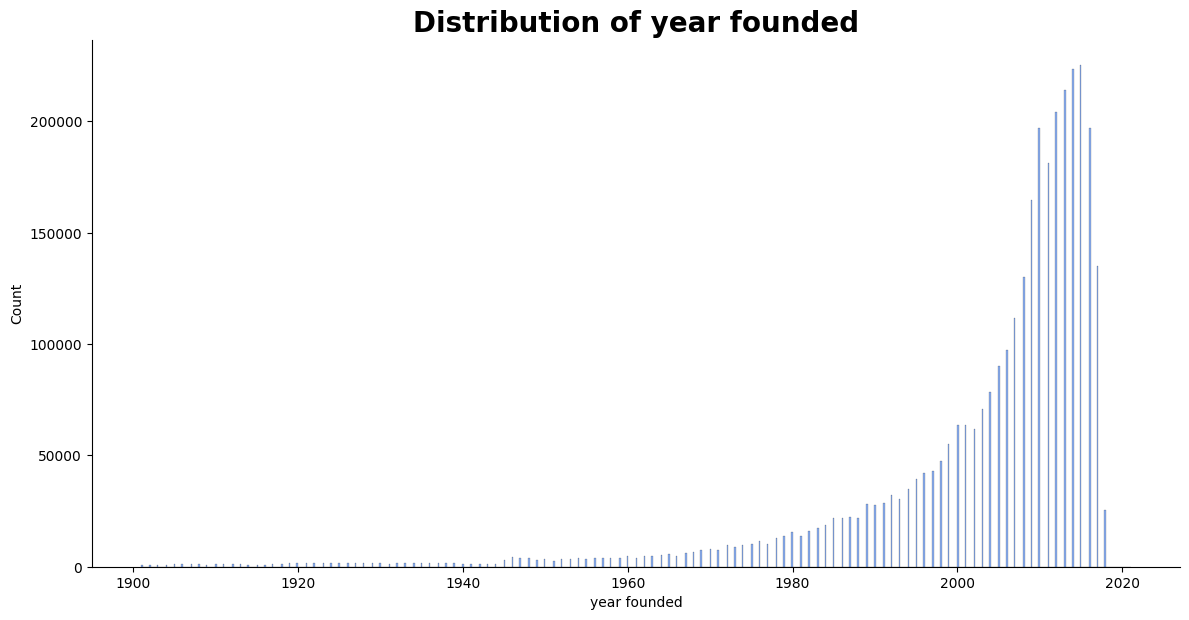

In [54]:
# distribution of companies founded after 1900
plot_dist(df[df['year founded'] > 1900], 'year founded')

### Industry

In [55]:
# unique value counts
counts_df = df['industry'].value_counts().rename_axis('industry').reset_index(name='count')
counts_df

industry   count
0    information technology and services  428200
1              marketing and advertising  319589
2                           construction  250232
3                  management consulting  185604
4                            real estate  185008
..                                   ...     ...
143                              fishery    2295
144                             ranching    2272
145                 railroad manufacture    1755
146                              tobacco    1324
147                   legislative office     499

[148 rows x 2 columns]

The companies in this dataset work in 148 industries. The most common industry is 'infomation technoogy and services'.

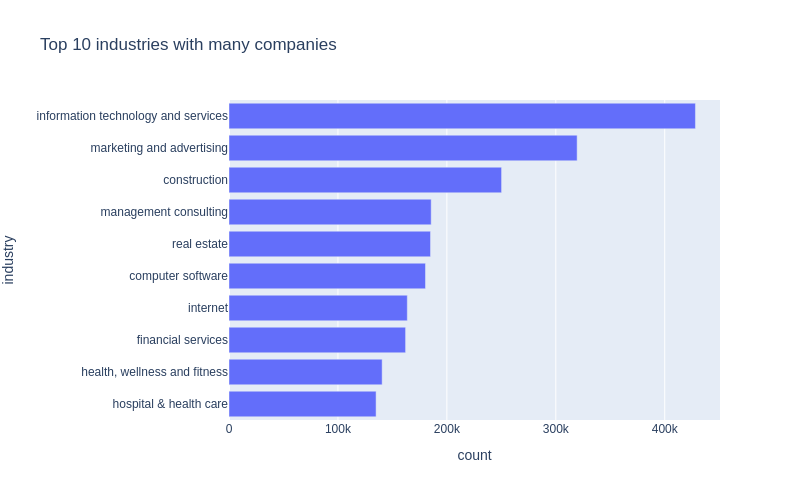

In [56]:
plotly_plot_bar(counts_df.nlargest(10, 'count').sort_values(by='count'), x='count', y='industry', title='Top 10 industries with many companies')

### Size range

In [57]:
# unique value counts
counts_df = df['size range'].value_counts().rename_axis('size range').reset_index(name='count')
counts_df

size range    count
0        1 - 10  5123116
1       11 - 50  1065971
2      51 - 200   294242
3     201 - 500    67694
4    501 - 1000    23581
5   1001 - 5000    19721
6  5001 - 10000     2259
7        10001+     1314

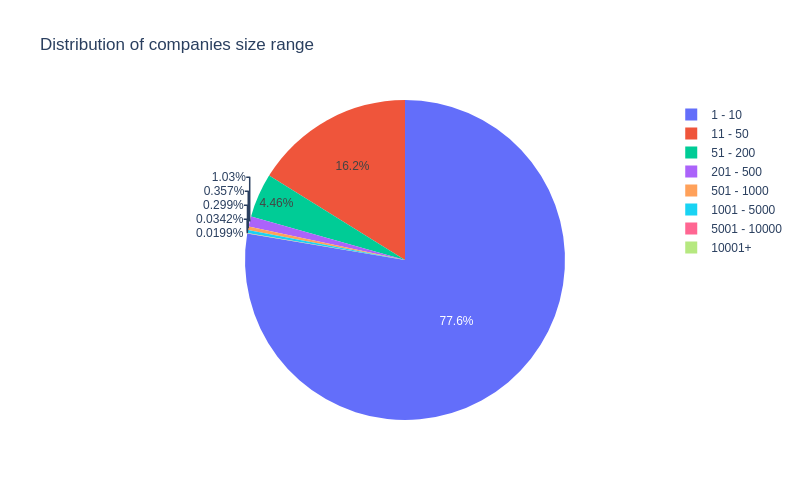

In [58]:
plotly_plot_pie(df, column='size range', title='Distribution of companies size range', width=800)

More than 93% of the companies have employees less than or equal to 50. I think this shows the reaity since the number of big companies that drive economies around the world is small.

### Locality

In [59]:
# unique value counts
counts_df = df['locality'].value_counts().rename_axis('locality').reset_index(name='count')
counts_df

locality  count
0                 london, greater london, united kingdom  81734
1                      new york, new york, united states  62181
2                                  madrid, madrid, spain  55484
3                           paris, île-de-france, france  32386
4                         london, london, united kingdom  29962
...                                                  ...    ...
94431                    ivychurch, kent, united kingdom      1
94432                           jarak, vojvodina, serbia      1
94433  wegrzce wielkie, lesser poland voivodeship, po...      1
94434                  tarnovo, veliko turnovo, bulgaria      1
94435       new manchester, west virginia, united states      1

[94436 rows x 2 columns]

Here we can see that most companies are found in the biggest cities of the developed world like london, new york, madrid and paris. Another thing to notice is that london appears both at index 0 and 4 with slight difference. This shows there is an inconsistency. We will extract the cities as a feature later to fix this.

### Country

In [60]:
# unique value counts
counts_df = df['country'].value_counts().rename_axis('country').reset_index(name='count')
counts_df

country    count
0                united states  2145990
1               united kingdom   473653
2                       canada   177528
3                        spain   138200
4                        india   135951
..                         ...      ...
231                       niue        1
232        u.s. virgin islands        1
233             norfolk island        1
234  saint pierre and miquelon        1
235           saint barthélemy        1

[236 rows x 2 columns]

Here also as expected most companies are from the developes countries.The top 10 countries with many companies are plotted below.

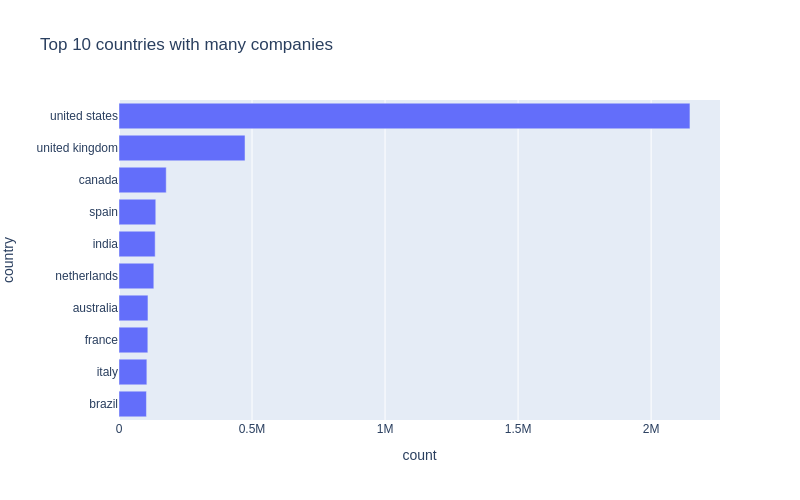

In [61]:
plotly_plot_bar(counts_df.nlargest(10, 'count').sort_values(by='count'), x='count', y='country', title='Top 10 countries with many companies')

 Companies from the united states clearly dominate the dataset.

### Linkedin url

In [62]:
counts_df = df['linkedin url'].value_counts().rename_axis('linkedin url').reset_index(name='count')
counts_df

linkedin url  count
0           linkedin.com/company/tata-consultancy-services      1
1                      linkedin.com/company/morgan-stanley      1
2                   linkedin.com/company/kaiser-permanente      1
3        linkedin.com/company/department-of-veterans-af...      1
4                              linkedin.com/company/pfizer      1
...                                                    ...    ...
6597893           linkedin.com/company/medexo-robotics-ltd      1
6597894           linkedin.com/company/scottish-owl-centre      1
6597895   linkedin.com/company/grund-chiropractic-wellness      1
6597896  linkedin.com/company/stone-center-for-yoga-&-h...      1
6597897  linkedin.com/company/dynamic-controls-solution...      1

[6597898 rows x 2 columns]

As shown above each company has its own unique linkedin url. This is because the name of the company, which is unique, is included in each url.

### Current employee estimate

In [63]:
counts_df = df['current employee estimate'].value_counts().rename_axis('current employee estimate').reset_index(name='count')
counts_df

current employee estimate    count
0                             1  2331718
1                             0  1179271
2                             2   926207
3                             3   473327
4                             4   292860
...                         ...      ...
4482                       3716        1
4483                       1355        1
4484                       3712        1
4485                       3710        1
4486                     190771        1

[4487 rows x 2 columns]

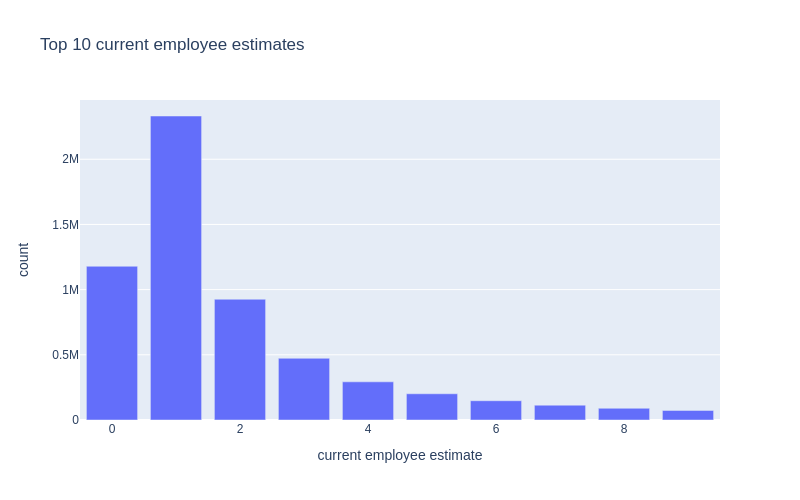

In [64]:
plotly_plot_bar(counts_df.nlargest(10, 'count').sort_values(by='count'), x='current employee estimate', y='count', title='Top 10 current employee estimates')

Everything seems fine here except for companies with 0 current employee estimate. I assume the data was not available for this companies so 0 was filled as an indication for missing.

### Total employee estimate

In [65]:
counts_df = df['total employee estimate'].value_counts().rename_axis('total employee estimate').reset_index(name='count')
counts_df

total employee estimate    count
0                           1  2302983
1                           2  1043087
2                           3   576626
3                           4   376018
4                           5   268765
...                       ...      ...
7222                     2925        1
7223                     6526        1
7224                     5560        1
7225                     5469        1
7226                   341369        1

[7227 rows x 2 columns]

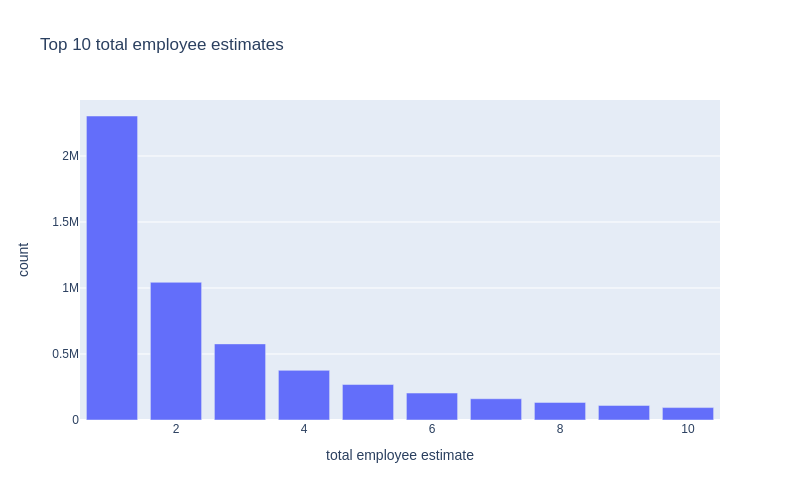

In [66]:
plotly_plot_bar(counts_df.nlargest(10, 'count').sort_values(by='count'), x='total employee estimate', y='count', title='Top 10 total employee estimates')

Here 0 is the mode value for total employee estimate. I assume this is also due to missing data.

## Feature Engineering

From the locality column we can extract city which is useful to tackle the inconsistency discussed above in the univariate analysis of locality.

In [67]:
def extract_city(locality):
    if pd.isnull(locality):
        return '<NA>'
    # extract cities from locality
    geo = geotext.GeoText(locality).cities
    if len(geo) > 0:
        return geo[0]
    return locality.split(',')[0]

df['city'] = df['locality'].apply(extract_city)

From the name we can extract different features like number of characters, words and punctuations. Another feature to be considered is word density. We can also identify if a name contains digits or non-aschii characters.

In [68]:
df['name_char_count'] = df['name'].apply(lambda name: len(name))

# split name based on comma, space or hyphen
df['name_word_count'] = df['name'].apply(lambda name: len(list(filter(lambda x: x!= '', re.split(r',|\s|-', name)))))

df['name_word_density'] = round(df['name_word_count'] / df['name_char_count'], 2)

punc = string.punctuation
df['name_punc_count'] = df['name'].apply(lambda x : len([a for a in x if a in punc]))

df['name_non_aschii_char_count'] = df['name'].apply(lambda x: len([a for a in x if ord(a) > 127]))

df['name_digit_count'] = df['name'].apply(lambda x: len([a for a in x if a in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']]))

For simplicity and ease of calculating correlation I will categorize the values of 'size range' into number values in an another column.

In [69]:
def categorize(size):
    switcher={
        '1 - 10': 1,
        '11 - 50': 2,
        '51 - 200': 3,
        '201 - 500': 4,
        '501 - 1000': 5,
        '1001 - 5000': 6,
        '5001 - 10000': 7,
        '10001+': 8
    }
    return switcher.get(size, 0)
df['size_category'] = df['size range'].apply(categorize)

In [70]:
df.sample(5)

name                domain  year founded  \
5595796              morito aps             morito.dk             0   
4591056              thera-peds                  <NA>             0   
1291195         tate consulting     tateconsulting.eu             0   
3991511  weber ultrasonics gmbh  weber-ultrasonics.de             0   
3693004       px3 brain science       p3mouthwear.com             0   

                             industry size range  \
5595796              executive office     1 - 10   
4591056              medical practice     1 - 10   
1291195                  construction    11 - 50   
3991511                consumer goods     1 - 10   
3693004  health, wellness and fitness     1 - 10   

                                         locality         country  \
5595796                                      <NA>            <NA>   
4591056  goldsboro, north carolina, united states   united states   
1291195              leeds, leeds, united kingdom  united kingdom   
3991511                                      <NA>            <NA>   
3693004                                      <NA>            <NA>   

                                        linkedin url  \
5595796              linkedin.com/company/morito-aps   
4591056              linkedin.com/company/thera-peds   
1291195         linkedin.com/company/tate-consulting   
3991511  linkedin.com/company/weber-ultrasonics-gmbh   
3693004            linkedin.com/company/p3-mouthwear   

         current employee estimate  total employee estimate       city  \
5595796                          1                        1       <NA>   
4591056                          1                        2  goldsboro   
1291195                          6                       13      leeds   
3991511                          1                        1       <NA>   
3693004                          1                        1       <NA>   

         name_char_count  name_word_count  name_word_density  name_punc_count  \
5595796               10                2               0.20                0   
4591056               10                2               0.20                1   
1291195               15                2               0.13                0   
3991511               22                3               0.14                0   
3693004               17                3               0.18                0   

         name_non_aschii_char_count  name_digit_count  size_category  
5595796                           0                 0              1  
4591056                           0                 0              1  
1291195                           0                 0              2  
3991511                           0                 0              1  
3693004                           0                 1              1

## Correlation Analysis

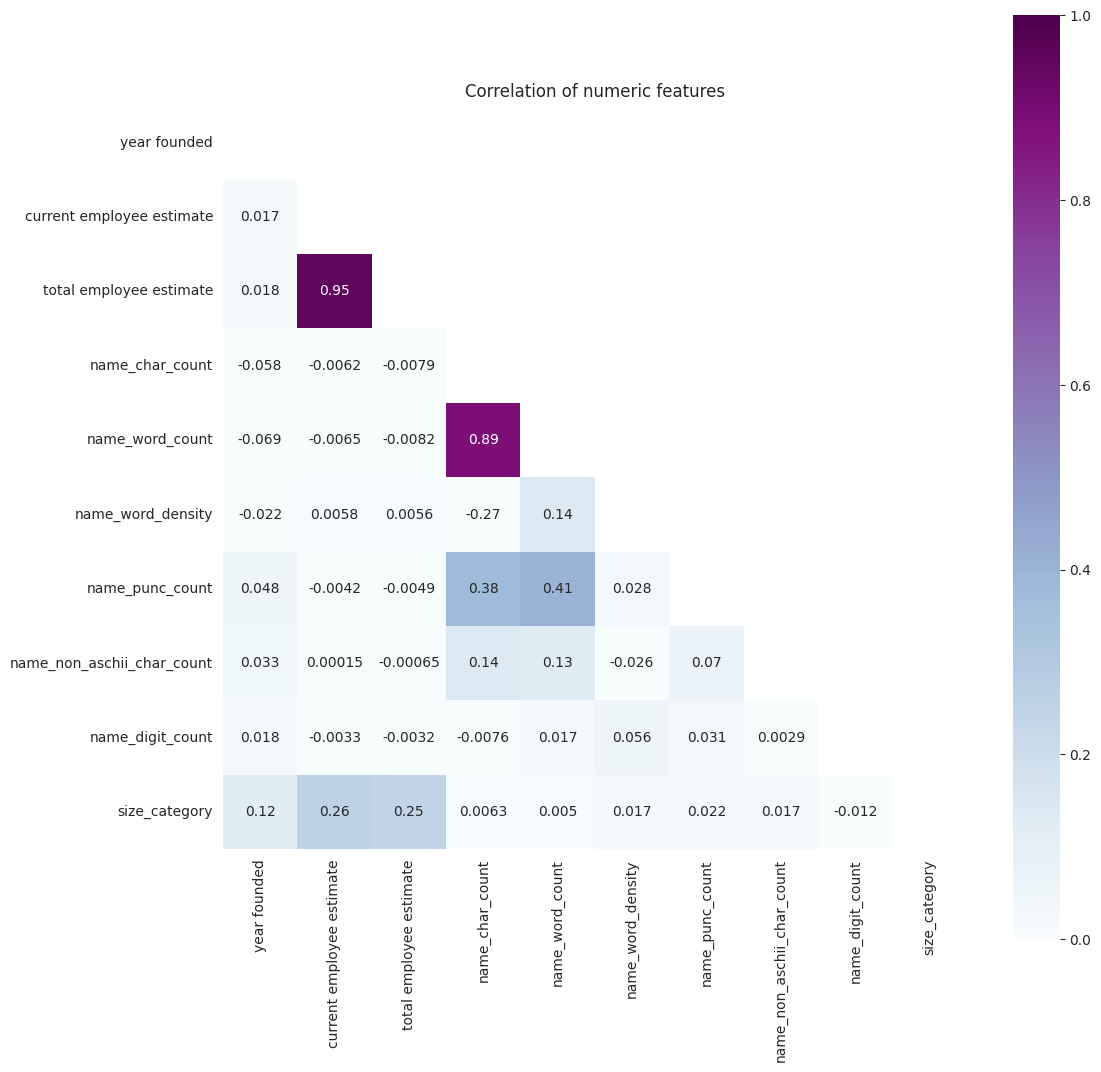

In [71]:
df_corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(df_corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f_fig, f_ax = plt.subplots(figsize=(12, 12))
    f_ax = sns.heatmap(df_corr, mask=mask, vmin=0, vmax=1, square=True,
                        annot=True, annot_kws={"size": 10}, cmap="BuPu")
plt.title('Correlation of numeric features')
plt.show()

As shown above there is no significant correlation between important numeric features. It is no surprise that 'current employee estimate' and 'total employee estimate' are highly correlated as they both describe the size of employees in companies. The same applies to numeric features engineered from the column name. They have correlation because they are derived from the same place. Due to these facts our bivariate analysis will mostly focus on non-numerical features and their interaction with the numerical features.

## Bivariate Analysis

### country and name_char_count

Here we will examine the averege number of characters in company names per countries.

In [72]:
country_df = df.groupby('country', as_index=False).agg({'name_char_count': 'mean', 'name': 'count'}).rename(columns={'name_char_count': 'mean_name_char', 'name': 'count'})
country_df =  country_df[country_df['count'] >= 100].sort_values(by='mean_name_char',ascending=False).reset_index(drop=True)
country_df['country'] = country_df['country'].astype('string').str.title()
country_df['mean_name_char'] = country_df['mean_name_char'].astype('int16')
country_df

country  mean_name_char   count
0                  China              28   35189
1    Trinidad And Tobago              27     461
2                  Yemen              27     113
3                  Sudan              26     299
4                 Kuwait              26    1669
..                   ...             ...     ...
160               Norway              16   24390
161               France              16  108366
162              Denmark              16   27671
163              Iceland              16     965
164              Estonia              15    3130

[165 rows x 3 columns]

In [73]:
gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))[['name', 'geometry']]
gdf.columns = ['country', 'geometry']
gdf.head()

country                                           geometry
0                      Fiji  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...
1                  Tanzania  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...
2                 W. Sahara  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...
3                    Canada  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...
4  United States of America  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...

In [74]:
# remove antarctica
antarctic_index = int(gdf[gdf['country'] == 'Antarctica'].index.values)
gdf = gdf.drop(gdf.index[antarctic_index])

replace = {
    "United States of America": 'United States',
    "Bosnia and Herz.": 'Bosnia And Herzegovina',
    "Central African Rep.": 'Central African Republic',
    "Côte d'Ivoire": 'Côte D’Ivoire',
    "Dominican Rep.": 'Dominican Republic',
    "Dem. Rep. Congo": 'Democratic Republic Of The Congo',
    "Eq. Guinea": 'Equatorial Guinea',
    "Dominican Rep.": 'Dominican Republic',
    "Solomon Is.": 'Solomon Islands',
    "Trinidad and Tobago": 'Trinidad And Tobago',
    "S. Sudan": 'South Sudan',
}

for (n_old, n_new) in replace.items():
    gdf.country.loc[gdf['country'] == n_old] = n_new

# merge country_df and gdf
merged = gdf.merge(country_df, left_on='country', right_on='country', how = 'left')
merged.head()

country                                           geometry  \
0           Fiji  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...   
1       Tanzania  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...   
2      W. Sahara  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...   
3         Canada  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...   
4  United States  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...   

   mean_name_char      count  
0            25.0     1252.0  
1            22.0     1031.0  
2             NaN        NaN  
3            22.0   177528.0  
4            21.0  2145990.0

In [77]:
pip install --upgrade mapclassify


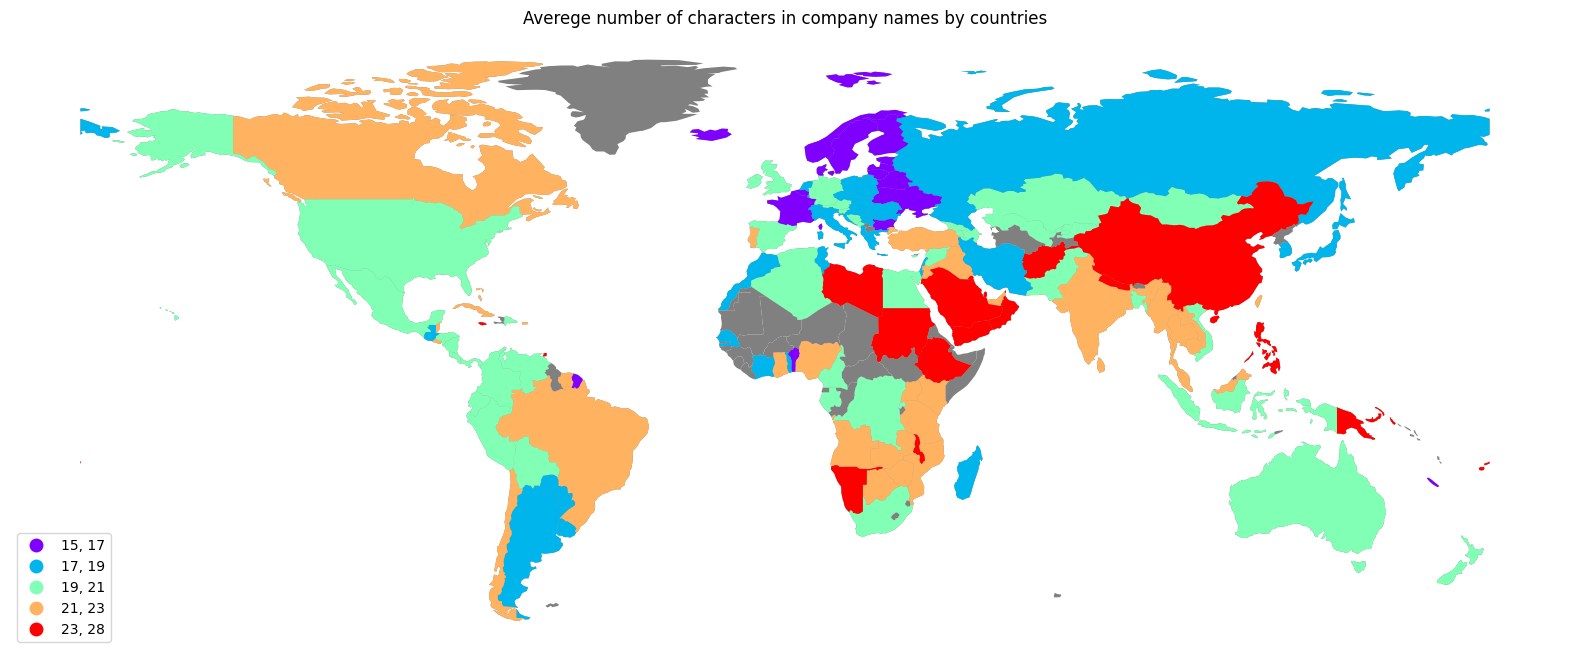

In [78]:
fig, ax = plt.subplots(1, figsize=(20,15))

merged.plot(color='grey', ax=ax, label = 'No data')
merged.dropna().plot(column='mean_name_char', cmap='rainbow', ax=ax, scheme='natural_breaks', k=5, legend=True, legend_kwds={'loc': 'lower left'})

plt.title('Averege number of characters in company names by countries')

#fixing floating-point counts, making them integer:
leg = ax.get_legend()
for text in leg.get_texts():
    text.set_text(text.get_text().replace('.00', ''))

plt.axis('off');

### country and name_word_count

Here we will investigate the averege number of words in company names per countries.

In [79]:
country_df = df.groupby('country', as_index=False).agg({'name_word_count': 'mean', 'name': 'count'}).rename(columns={'name_word_count': 'mean_name_word', 'name': 'count'})
country_df =  country_df[country_df['count'] >= 100].sort_values(by='mean_name_word',ascending=False).reset_index(drop=True)
country_df['country'] = country_df['country'].astype('string').str.title()
country_df['mean_name_word'] = country_df['mean_name_word'].astype('int16')
country_df

country  mean_name_word   count
0      China               4   35189
1      Yemen               3     113
2       Oman               3    1277
3     Kuwait               3    1669
4      Sudan               3     299
..       ...             ...     ...
160   France               2  108366
161  Estonia               2    3130
162  Denmark               2   27671
163  Belarus               2     984
164  Iceland               2     965

[165 rows x 3 columns]

In [80]:
# merge country_df and gdf
merged = gdf.merge(country_df, left_on='country', right_on='country', how = 'left')
merged.head()

country                                           geometry  \
0           Fiji  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...   
1       Tanzania  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...   
2      W. Sahara  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...   
3         Canada  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...   
4  United States  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...   

   mean_name_word      count  
0             3.0     1252.0  
1             3.0     1031.0  
2             NaN        NaN  
3             3.0   177528.0  
4             3.0  2145990.0

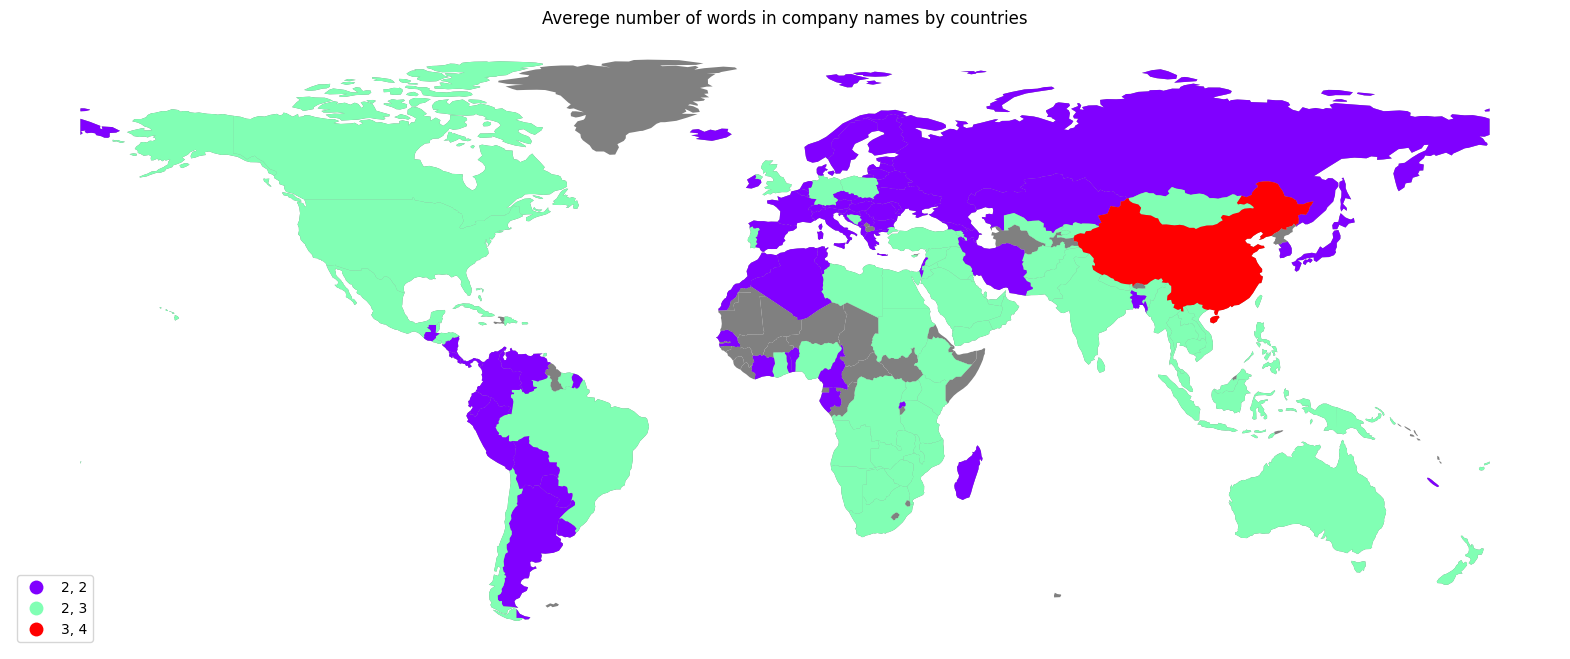

In [81]:
fig, ax = plt.subplots(1, figsize=(20,15))

merged.plot(color='grey', ax=ax, label = 'No data')
merged.dropna().plot(column='mean_name_word', cmap='rainbow', ax=ax, scheme='natural_breaks', k=3, legend=True, legend_kwds={'loc': 'lower left'})

plt.title('Averege number of words in company names by countries')

#fixing floating-point counts, making them integer:
leg = ax.get_legend()
for text in leg.get_texts():
    text.set_text(text.get_text().replace('.00', ''))

plt.axis('off');

There is high similarity with the map showing averege number of characters in company names by countries. It is obvious as there is a correlation between number of characters and words. Some countries with high average number of characters have medium average number of words. I assume the words used by these countries are longer.

### country and name_punc_count

Now it is time for investigating the averege number of punctuations in company names per countries.

In [82]:
country_df = df.groupby('country', as_index=False).agg({'name_punc_count': 'mean', 'name': 'count'}).rename(columns={'name_punc_count': 'mean_name_punct_count', 'name': 'count'})
country_df =  country_df[country_df['count'] >= 100].sort_values(by='mean_name_punct_count',ascending=False).reset_index(drop=True)
country_df['country'] = country_df['country'].astype('string').str.title()
country_df['mean_name_punct_count'] = country_df['mean_name_punct_count'].round(2)
country_df

country  mean_name_punct_count   count
0           Czechia                   1.59   12085
1          Slovenia                   1.49    3098
2          Slovakia                   1.48    4017
3             China                   1.36   35189
4           Croatia                   1.20    4448
..              ...                    ...     ...
160       Australia                   0.21  108841
161  United Kingdom                   0.20  473653
162         Estonia                   0.20    3130
163          Norway                   0.19   24390
164          Sweden                   0.16   33329

[165 rows x 3 columns]

In [83]:
# merge country_df and gdf
merged = gdf.merge(country_df, left_on='country', right_on='country', how = 'left')
merged.head()

country                                           geometry  \
0           Fiji  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...   
1       Tanzania  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...   
2      W. Sahara  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...   
3         Canada  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...   
4  United States  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...   

   mean_name_punct_count      count  
0                   0.57     1252.0  
1                   0.37     1031.0  
2                    NaN        NaN  
3                   0.48   177528.0  
4                   0.42  2145990.0

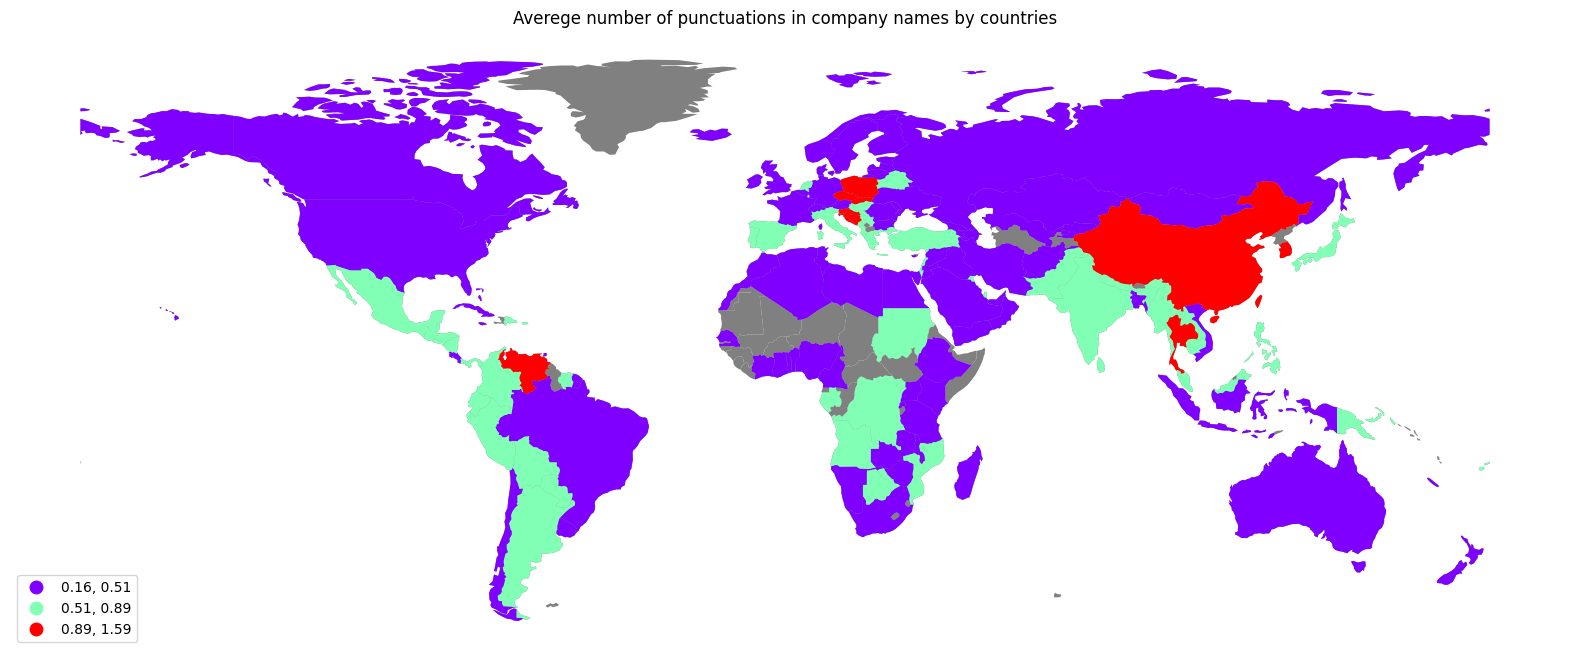

In [84]:
fig, ax = plt.subplots(1, figsize=(20,15))

merged.plot(color='grey', ax=ax, label = 'No data')
merged.dropna().plot(column='mean_name_punct_count', cmap='rainbow', ax=ax, scheme='natural_breaks', k=3, legend=True, legend_kwds={'loc': 'lower left'})

plt.title('Averege number of punctuations in company names by countries')

#fixing floating-point counts, making them integer:
leg = ax.get_legend()
for text in leg.get_texts():
    text.set_text(text.get_text().replace('.00', ''))

plt.axis('off');

Some countries in europe, the south east asia and south america have company names with a high probability of including a punctuation. Let's see who they are.

In [85]:
country_df[country_df['mean_name_punct_count'] >= 1]

country  mean_name_punct_count  count
0                 Czechia                   1.59  12085
1                Slovenia                   1.49   3098
2                Slovakia                   1.48   4017
3                   China                   1.36  35189
4                 Croatia                   1.20   4448
5               Venezuela                   1.06   3745
6                Thailand                   1.04   5398
7                  Taiwan                   1.04   3301
8  Bosnia And Herzegovina                   1.02    945

### country and name_digit_count

Digits are not that much common in company name. But they appear in some names to represent something, for example, the year they were founded. Let's see if there is a relation between country and average number of digits in company names.

In [86]:
country_df = df.groupby('country', as_index=False).agg({'name_digit_count': 'mean', 'name': 'count'}).rename(columns={'name_digit_count': 'mean_name_digit_count', 'name': 'count'})
country_df =  country_df[country_df['count'] >= 100].sort_values(by='mean_name_digit_count',ascending=False).reset_index(drop=True)
country_df['country'] = country_df['country'].astype('string').str.title()
country_df['mean_name_digit_count'] = country_df['mean_name_digit_count'].round(2)
country_df

country  mean_name_digit_count  count
0         Taiwan                   0.15   3301
1     Guadeloupe                   0.12    165
2    South Korea                   0.11   2047
3      Venezuela                   0.10   3745
4        Albania                   0.08    735
..           ...                    ...    ...
160         Oman                   0.01   1277
161         Iraq                   0.01    735
162      Bahamas                   0.00    290
163   Seychelles                   0.00    127
164        Yemen                   0.00    113

[165 rows x 3 columns]

The maximum value for average count of digits per country is 0.15 which is very low. This is expected as most company names doesn't include digits.

In [87]:
# merge country_df and gdf
merged = gdf.merge(country_df, left_on='country', right_on='country', how = 'left')
merged.head()

country                                           geometry  \
0           Fiji  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...   
1       Tanzania  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...   
2      W. Sahara  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...   
3         Canada  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...   
4  United States  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...   

   mean_name_digit_count      count  
0                   0.02     1252.0  
1                   0.04     1031.0  
2                    NaN        NaN  
3                   0.05   177528.0  
4                   0.04  2145990.0

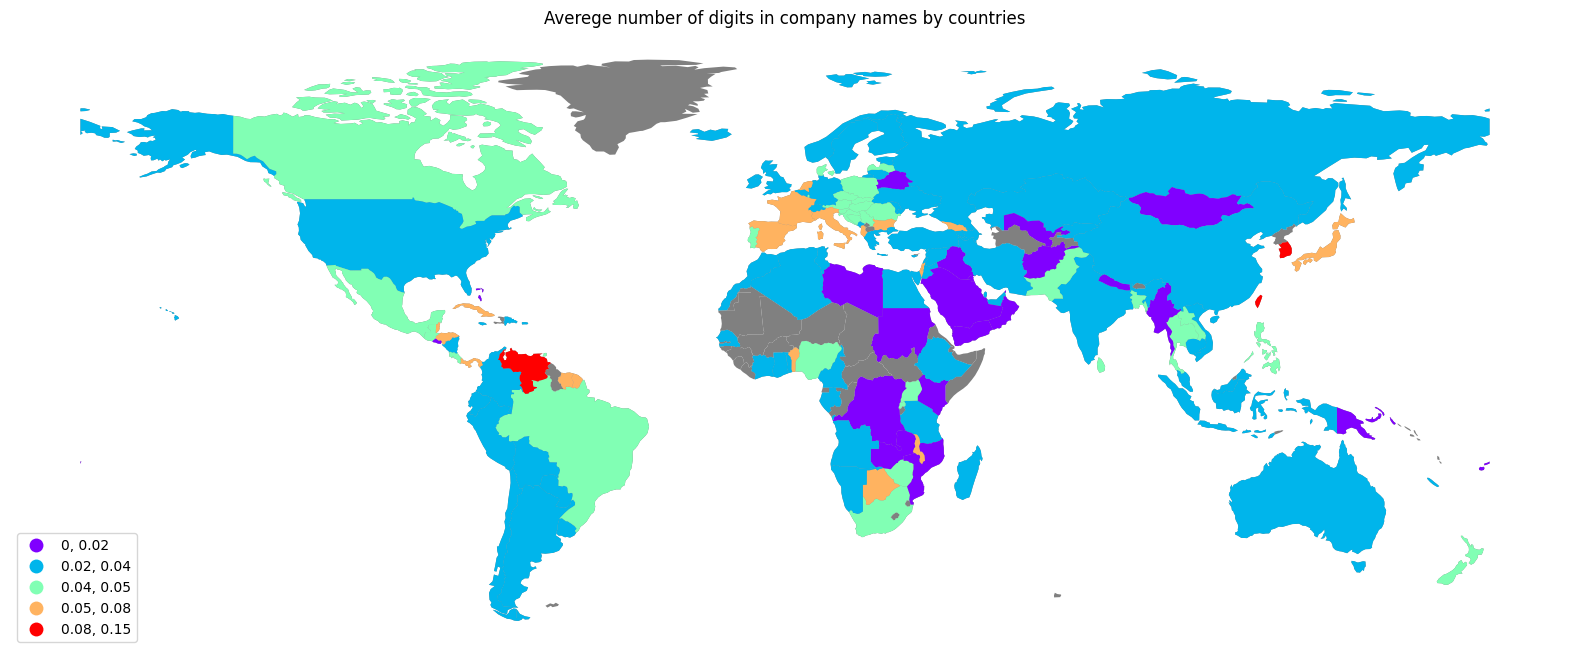

In [88]:
fig, ax = plt.subplots(1, figsize=(20,15))

merged.plot(color='grey', ax=ax, label = 'No data')
merged.dropna().plot(column='mean_name_digit_count', cmap='rainbow', ax=ax, scheme='natural_breaks', k=5, legend=True, legend_kwds={'loc': 'lower left'})

plt.title('Averege number of digits in company names by countries')

#fixing floating-point counts, making them integer:
leg = ax.get_legend()
for text in leg.get_texts():
    text.set_text(text.get_text().replace('.00', ''))

plt.axis('off');

In [89]:
country_df[country_df['mean_name_digit_count'] > 0.07]

country  mean_name_digit_count  count
0       Taiwan                   0.15   3301
1   Guadeloupe                   0.12    165
2  South Korea                   0.11   2047
3    Venezuela                   0.10   3745
4      Albania                   0.08    735
5      Curaçao                   0.08    239

### country and name_non_aschii_char_count

Company names with non-aschii characters are probably going to be from non-english speaking countries. But the question is which countries have the highest number of average non-aschii characters. Let's find out.

In [90]:
country_df = df.groupby('country', as_index=False).agg({'name_non_aschii_char_count': 'mean', 'name': 'count'}).rename(columns={'name_non_aschii_char_count': 'mean_name_non_aschii_char_count', 'name': 'count'})
country_df =  country_df[country_df['count'] >= 100].sort_values(by='mean_name_non_aschii_char_count',ascending=False).reset_index(drop=True)
country_df['country'] = country_df['country'].astype('string').str.title()
country_df['mean_name_non_aschii_char_count'] = country_df['mean_name_non_aschii_char_count'].round(2)
country_df

country  mean_name_non_aschii_char_count  count
0       Belarus                             1.33    984
1        Russia                             1.14  11164
2        Turkey                             1.13  33898
3          Iran                             1.02   6864
4    Kazakhstan                             0.97    902
..          ...                              ...    ...
160     Bahamas                             0.00    290
161    Tanzania                             0.00   1031
162      Zambia                             0.00    466
163    Botswana                             0.00    289
164      Belize                             0.00    211

[165 rows x 3 columns]

In [91]:
# merge country_df and gdf
merged = gdf.merge(country_df, left_on='country', right_on='country', how = 'left')
merged.head()

country                                           geometry  \
0           Fiji  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...   
1       Tanzania  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...   
2      W. Sahara  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...   
3         Canada  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...   
4  United States  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...   

   mean_name_non_aschii_char_count      count  
0                             0.19     1252.0  
1                             0.00     1031.0  
2                              NaN        NaN  
3                             0.07   177528.0  
4                             0.01  2145990.0

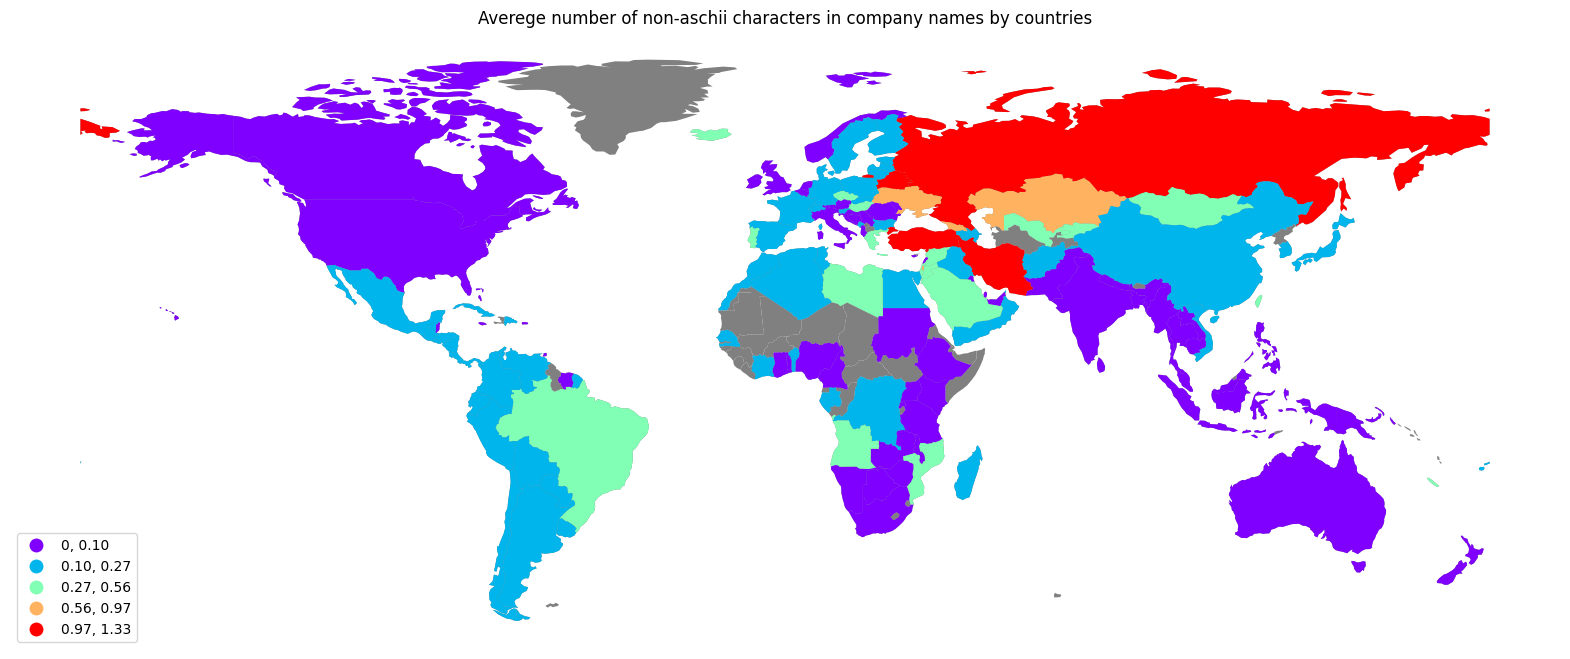

In [92]:
fig, ax = plt.subplots(1, figsize=(20,15))

merged.plot(color='grey', ax=ax, label = 'No data')
merged.dropna().plot(column='mean_name_non_aschii_char_count', cmap='rainbow', ax=ax, scheme='natural_breaks', k=5, legend=True, legend_kwds={'loc': 'lower left'})

plt.title('Averege number of non-aschii characters in company names by countries')

#fixing floating-point counts, making them integer:
leg = ax.get_legend()
for text in leg.get_texts():
    text.set_text(text.get_text().replace('.00', ''))

plt.axis('off');

Let's find out which countries are coded by red.

In [93]:
country_df[country_df['mean_name_non_aschii_char_count'] >= 0.97]

country  mean_name_non_aschii_char_count  count
0     Belarus                             1.33    984
1      Russia                             1.14  11164
2      Turkey                             1.13  33898
3        Iran                             1.02   6864
4  Kazakhstan                             0.97    902

### country and size range

In [94]:
country_df = df.groupby('country', as_index=False).agg({'size_category': 'mean', 'name': 'count'}).rename(columns={'size_category': 'mean_size_category', 'name': 'count'})
country_df =  country_df[country_df['count'] >= 100].sort_values(by='mean_size_category',ascending=False).reset_index(drop=True)
country_df['country'] = country_df['country'].astype('string').str.title()
country_df['mean_size_category'] = country_df['mean_size_category'].round(2)
country_df

country  mean_size_category    count
0    Papua New Guinea                1.82      222
1               Qatar                1.81     2208
2        Saudi Arabia                1.81     6778
3           Indonesia                1.74    14402
4                Oman                1.73     1277
..                ...                 ...      ...
160     United States                1.27  2145990
161        Martinique                1.26      141
162        Guadeloupe                1.25      165
163    United Kingdom                1.22   473653
164       Saint Lucia                1.21      307

[165 rows x 3 columns]

In [95]:
# merge country_df and gdf
merged = gdf.merge(country_df, left_on='country', right_on='country', how = 'left')
merged.head()

country                                           geometry  \
0           Fiji  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...   
1       Tanzania  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...   
2      W. Sahara  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...   
3         Canada  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...   
4  United States  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...   

   mean_size_category      count  
0                1.68     1252.0  
1                1.51     1031.0  
2                 NaN        NaN  
3                1.33   177528.0  
4                1.27  2145990.0

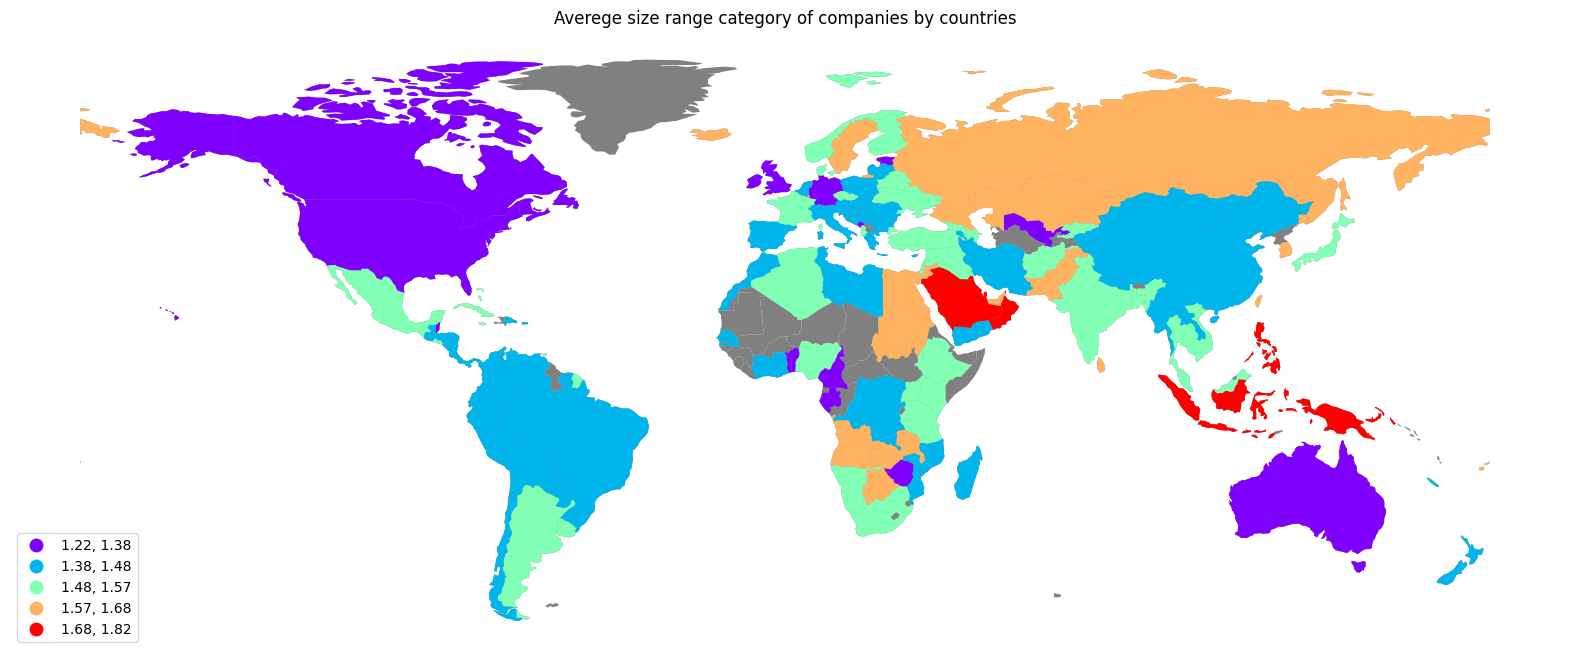

In [96]:
fig, ax = plt.subplots(1, figsize=(20,15))

merged.plot(color='grey', ax=ax, label = 'No data')
merged.dropna().plot(column='mean_size_category', cmap='rainbow', ax=ax, scheme='natural_breaks', k=5, legend=True, legend_kwds={'loc': 'lower left'})

plt.title('Averege size range category of companies by countries')

#fixing floating-point counts, making them integer:
leg = ax.get_legend()
for text in leg.get_texts():
    text.set_text(text.get_text().replace('.00', ''))

plt.axis('off');

The mean size category ranges from 1.23 to 1.88 in every country with more than or equal to 100 companies in the dataset. This indicates that there are many small companies in these countries which is obvious. That is why the average is lower.

### name and industry

Here we will examine how many and which companies contain words from their respective industries in their names.

In [97]:
def industry_in_name(row):
    puncs = [punc for punc in string.punctuation]
    puncs.append('and')
    industry_words = set(filter(lambda x: x not in puncs, re.split(r'\s|-', row['industry'])))
    name_words = re.split(r'\s|-', row['name'])
    return len([i for i in name_words if i in industry_words])
df['industry_word_in_name_count'] = df.apply(industry_in_name, axis=1)

In [98]:
name_industry_df = df[df['industry_word_in_name_count'] > 0]
name_industry_df

name                    domain  \
1              tata consultancy services                   tcs.com   
136          nyc department of education                   nyc.gov   
211       social security administration        socialsecurity.gov   
240                       lg electronics                    lg.com   
260              alberta health services  albertahealthservices.ca   
...                                  ...                       ...   
7173386   agile4ever consulting services            agile4ever.com   
7173398      grund chiropractic wellness                      <NA>   
7173405  nextmotion mobility engineering             nextmotion.pt   
7173413    a w hargrove insurance agency                      <NA>   
7173418            koop media management                      <NA>   

         year founded                              industry size range  \
1                1968   information technology and services     10001+   
136                 0                  education management     10001+   
211              1935             government administration     10001+   
240              1947                  consumer electronics     10001+   
260              2008                hospital & health care     10001+   
...               ...                                   ...        ...   
7173386          2013                 management consulting     1 - 10   
7173398             0          health, wellness and fitness     1 - 10   
7173405          2012  mechanical or industrial engineering     1 - 10   
7173413             0                             insurance     1 - 10   
7173418             0                       broadcast media     1 - 10   

                                       locality         country  \
1                    bombay, maharashtra, india           india   
136           new york, new york, united states   united states   
211          baltimore, maryland, united states   united states   
240        seoul, seoul-t'ukpyolsi, south korea     south korea   
260                   edmonton, alberta, canada          canada   
...                                         ...             ...   
7173386  london, greater london, united kingdom  united kingdom   
7173398   santa rosa, california, united states   united states   
7173405                                    <NA>            <NA>   
7173413         exmore, virginia, united states   united states   
7173418                                    <NA>            <NA>   

                                              linkedin url  \
1           linkedin.com/company/tata-consultancy-services   
136       linkedin.com/company/nyc-department-of-education   
211                               linkedin.com/company/ssa   
240                    linkedin.com/company/lg-electronics   
260           linkedin.com/company/alberta-health-services   
...                                                    ...   
7173386  linkedin.com/company/agile4ever-consulting-ser...   
7173398   linkedin.com/company/grund-chiropractic-wellness   
7173405                    linkedin.com/company/nextmotion   
7173413  linkedin.com/company/a-w-hargrove-insurance-ag...   
7173418         linkedin.com/company/koop-media-management   

         current employee estimate  total employee estimate        city  \
1                           190771                   341369      bombay   
136                          30526                    45049    new york   
211                          21150                    28143   baltimore   
240                          19552                    47846       seoul   
260                          18502                    24861    edmonton   
...                            ...                      ...         ...   
7173386                          0                        2      london   
7173398                          0                        1  santa rosa   
7173405                          0                        1        <NA>   
717341

Let's explore these companies with respect to their country, size range, industry and year founded.

#### industry_word_in_name_count and country

In [99]:
country_df = name_industry_df.groupby('country', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
country_df =  country_df.sort_values(by='count',ascending=False).reset_index(drop=True)
country_counts_df = df['country'].value_counts().rename_axis('country').reset_index(name='total_count')
country_df = country_df.merge(country_counts_df, left_on='country', right_on='country', how = 'left')
country_df['country'] = country_df['country'].astype('string').str.title()
country_df

country   count  total_count
0          United States  241972      2145990
1         United Kingdom   49553       473653
2                 Canada   22339       177528
3                  India   13845       135951
4              Australia   12954       108841
..                   ...     ...          ...
213           Micronesia       1            5
214  U.S. Virgin Islands       1            1
215               Tuvalu       1           23
216               Guyana       1           48
217                Samoa       1           23

[218 rows x 3 columns]

In [100]:
# merge country_df and gdf
merged = gdf.merge(country_df, left_on='country', right_on='country', how = 'left')
merged.head()

country                                           geometry     count  \
0           Fiji  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...     154.0   
1       Tanzania  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...     109.0   
2      W. Sahara  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...       NaN   
3         Canada  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...   22339.0   
4  United States  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...  241972.0   

   total_count  
0         1252  
1         1031  
2         <NA>  
3       177528  
4      2145990

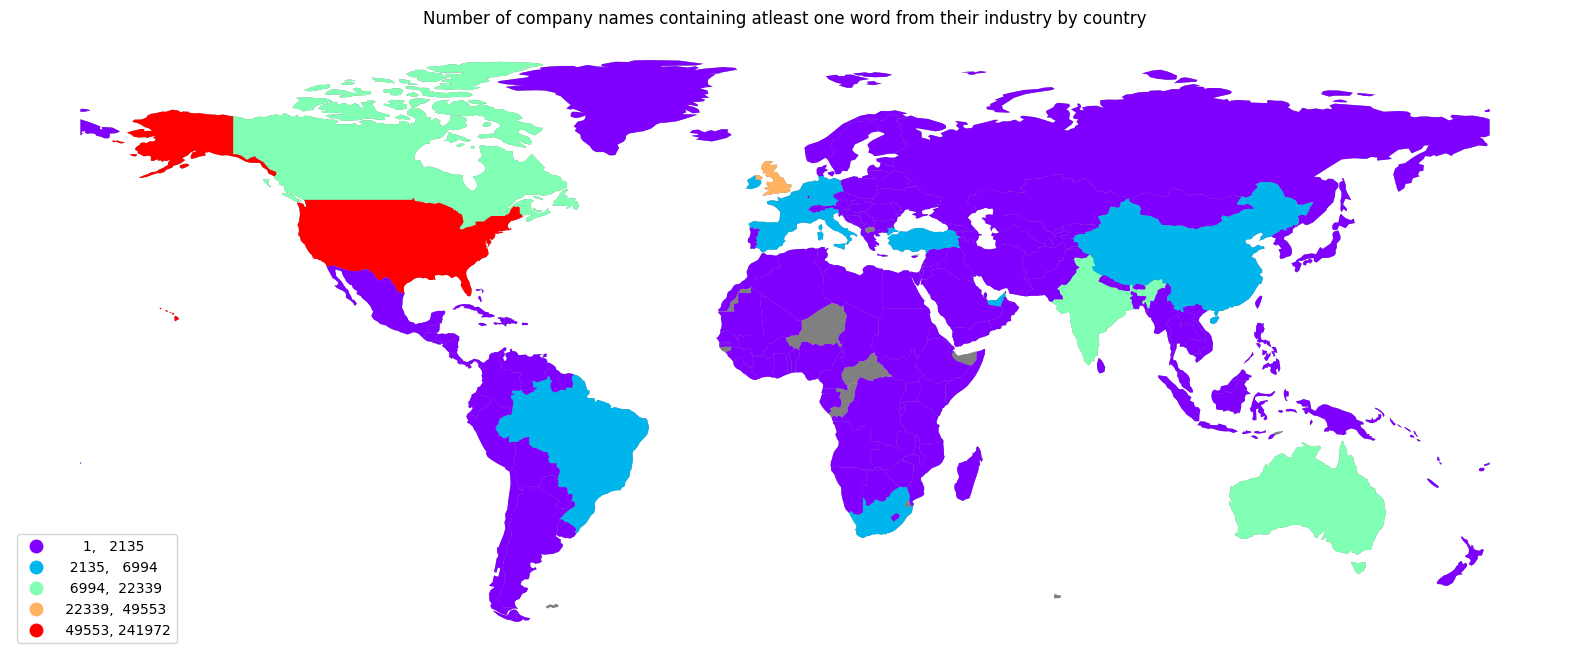

In [101]:
fig, ax = plt.subplots(1, figsize=(20,15))

merged.plot(color='grey', ax=ax, label = 'No data')
merged.dropna().plot(column='count', cmap='rainbow', ax=ax, scheme='natural_breaks', k=5, legend=True, legend_kwds={'loc': 'lower left'})

plt.title('Number of company names containing atleast one word from their industry by country')

#fixing floating-point counts, making them integer:
leg = ax.get_legend()
for text in leg.get_texts():
    text.set_text(text.get_text().replace('.00', ''))

plt.axis('off');

The united states dominates here. But this maybe due to its high number of companies in the dataset as compared to other companies.

#### industry_word_in_name_count and size range

Let us check if these names are related to size range.

In [ ]:
size_df = name_industry_df.groupby('size range', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
size_counts_df = df['size range'].value_counts().rename_axis('size range').reset_index(name='total_count')
size_df = size_df.merge(size_counts_df, left_on='size range', right_on='size range', how = 'left')
size_df =  size_df.sort_values(by='count',ascending=False).reset_index(drop=True)
size_df

As we can see from the result above, small sized companies tend to have more companies with names conataining atleast a word from their respective industries. This aligns with the general distibution of size range. So I don't think there is a special connection here.

#### industry_word_in_name_count and industry

Let us check if these names are related to which industry.

In [ ]:
industry_df = name_industry_df.groupby('industry', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
industry_counts_df = df['industry'].value_counts().rename_axis('industry').reset_index(name='total_count')
industry_df = industry_df.merge(industry_counts_df, left_on='industry', right_on='industry', how = 'left')
industry_df =  industry_df.sort_values(by='count',ascending=False).reset_index(drop=True)
industry_df

In [ ]:
industry_df.head(10)

In [ ]:
plotly_plot_bar(industry_df.nlargest(10, 'count').sort_values(by='count'), x='count', y='industry', title='Top 10 industries with atleast one word from their industry in their company names')

The bar chart plotted above shows top 10 industries with words from their respective industry in their company names.

#### industry_word_in_name_count and year founded

In [ ]:
year_df = name_industry_df.groupby('year founded', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
year_df = year_df[year_df['year founded'] != 0]
year_counts_df = df['year founded'].value_counts().rename_axis('year founded').reset_index(name='total_count')
year_df = year_df.merge(year_counts_df, left_on='year founded', right_on='year founded', how = 'left')
year_df =  year_df.sort_values(by='count',ascending=False).reset_index(drop=True)
year_df['year founded'] = year_df['year founded'].astype('string')
year_df

In [ ]:
year_df.head(10)

In [ ]:
plotly_plot_bar(year_df.nlargest(10, 'count').sort_values(by='count'), x='count', y='year founded', title='Top 10 years where companies with atleast one word from their industry in their names were founded')

### name and locality

Here we will examine how many and which companies contain words from their respective localities in their names.

In [ ]:
def locality_in_name(row):
    if pd.isnull(row['locality']):
        return np.nan
    puncs = [punc for punc in string.punctuation]
    puncs.append('and')
    locality_words = set(filter(lambda x: x not in puncs, re.split(r'\s|-', row['locality'])))
    name_words = re.split(r'\s|-', row['name'])
    return len([i for i in name_words if i in locality_words])
df['locality_word_in_name_count'] = df.apply(locality_in_name, axis=1)

In [ ]:
name_locality_df = df[df['locality_word_in_name_count'] > 0]
name_locality_df

Let's explore these companies with respect to their country, size range, industry and year founded.

#### locality_word_in_name_count and country

In [ ]:
country_df = name_locality_df.groupby('country', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
country_df =  country_df.sort_values(by='count',ascending=False).reset_index(drop=True)
country_counts_df = df['country'].value_counts().rename_axis('country').reset_index(name='total_count')
country_df = country_df.merge(country_counts_df, left_on='country', right_on='country', how = 'left')
country_df['country'] = country_df['country'].astype('string').str.title()
country_df

In [ ]:
# merge country_df and gdf
merged = gdf.merge(country_df, left_on='country', right_on='country', how = 'left')
merged.head()

In [ ]:
fig, ax = plt.subplots(1, figsize=(20,15))

merged.plot(color='grey', ax=ax, label = 'No data')
merged.dropna().plot(column='count', cmap='rainbow', ax=ax, scheme='natural_breaks', k=5, legend=True, legend_kwds={'loc': 'lower left'})

plt.title('Number of company names containing atleast one word from their locality by country')

#fixing floating-point counts, making them integer:
leg = ax.get_legend()
for text in leg.get_texts():
    text.set_text(text.get_text().replace('.00', ''))

plt.axis('off');

#### locality_word_in_name_count and size range

In [ ]:
size_df = name_locality_df.groupby('size range', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
size_counts_df = df['size range'].value_counts().rename_axis('size range').reset_index(name='total_count')
size_df = size_df.merge(size_counts_df, left_on='size range', right_on='size range', how = 'left')
size_df =  size_df.sort_values(by='count',ascending=False).reset_index(drop=True)
size_df

As we can see from the result above, small sized companies tend to have more companies with names conataining atleast a word from their respective localities. This aligns with the general distibution of size range. So I don't think there is a special connection here.

#### locality_word_in_name_count and industry

In [ ]:
industry_df = name_locality_df.groupby('industry', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
industry_counts_df = df['industry'].value_counts().rename_axis('industry').reset_index(name='total_count')
industry_df = industry_df.merge(industry_counts_df, left_on='industry', right_on='industry', how = 'left')
industry_df =  industry_df.sort_values(by='count',ascending=False).reset_index(drop=True)
industry_df

In [ ]:
industry_df.head(10)

In [ ]:
plotly_plot_bar(industry_df.nlargest(10, 'count').sort_values(by='count'), x='count', y='industry', title='Top 10 industries with atleast one word from their locality in their company names')

The bar chart plotted above shows top 10 industries with words from their respective locality in their company names.

#### locality_word_in_name_count and year founded

In [ ]:
year_df = name_locality_df.groupby('year founded', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
year_df = year_df[year_df['year founded'] != 0]
year_counts_df = df['year founded'].value_counts().rename_axis('year founded').reset_index(name='total_count')
year_df = year_df.merge(year_counts_df, left_on='year founded', right_on='year founded', how = 'left')
year_df =  year_df.sort_values(by='count',ascending=False).reset_index(drop=True)
year_df['year founded'] = year_df['year founded'].astype('string')
year_df

In [ ]:
year_df.head(10)

In [ ]:
plotly_plot_bar(year_df.nlargest(10, 'count').sort_values(by='count'), x='count', y='year founded', title='Top 10 years where companies with atleast one word from their locality in their names were founded')

### name and year founded

Here we will examine how many and which companies contain words from their respective years they were founded in their names.

In [ ]:
def year_in_name(row):
    if (row['year founded'] == 0):
        return None
    year = row['year founded']
    regexp = re.compile(f'{year}')
    return regexp.search(row['name'])

df['year_in_name'] = df.apply(year_in_name, axis=1).astype('bool').astype('int16')

In [ ]:
name_year_df = df[df['year_in_name'] > 0]
name_year_df

Let's explore these companies with respect to their country, size range, industry and year founded.

#### year_in_name and country

In [ ]:
country_df = name_year_df.groupby('country', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
country_df =  country_df.sort_values(by='count',ascending=False).reset_index(drop=True)
country_counts_df = df['country'].value_counts().rename_axis('country').reset_index(name='total_count')
country_df = country_df.merge(country_counts_df, left_on='country', right_on='country', how = 'left')
country_df['country'] = country_df['country'].astype('string').str.title()
country_df

In [ ]:
# merge country_df and gdf
merged = gdf.merge(country_df, left_on='country', right_on='country', how = 'left')
merged.head()

In [ ]:
fig, ax = plt.subplots(1, figsize=(20,15))

merged.plot(color='grey', ax=ax, label = 'No data')
merged.dropna().plot(column='count', cmap='rainbow', ax=ax, scheme='natural_breaks', k=5, legend=True, legend_kwds={'loc': 'lower left'})

plt.title('Number of company names containing the year they were founded by country')

#fixing floating-point counts, making them integer:
leg = ax.get_legend()
for text in leg.get_texts():
    text.set_text(text.get_text().replace('.00', ''))

plt.axis('off');

#### year_in_name and size range

Let us check if these names are related to size range.

In [ ]:
size_df = name_year_df.groupby('size range', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
size_counts_df = df['size range'].value_counts().rename_axis('size range').reset_index(name='total_count')
size_df = size_df.merge(size_counts_df, left_on='size range', right_on='size range', how = 'left')
size_df =  size_df.sort_values(by='count',ascending=False).reset_index(drop=True)
size_df

As we can see from the result above, if a company's name contains the year it was founded the company tends to have a small number of employees. Again this also aligns with the general distibution of size range. So I don't think there is a special connection here.

#### year_in_name and industry

Let us check if these names are related to which industry.

In [ ]:
industry_df = name_year_df.groupby('industry', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
industry_counts_df = df['industry'].value_counts().rename_axis('industry').reset_index(name='total_count')
industry_df = industry_df.merge(industry_counts_df, left_on='industry', right_on='industry', how = 'left')
industry_df =  industry_df.sort_values(by='count',ascending=False).reset_index(drop=True)
industry_df

In [ ]:
industry_df.head(10)

In [ ]:
plotly_plot_bar(industry_df.nlargest(10, 'count').sort_values(by='count'), x='count', y='industry', title='Top 10 industries with year founded in their companiy names')

The bar chart plotted above shows top 10 industries with year founded in their companiy names. I think that it is obvious that sport companies are very associated with the year they were founded. The table above also proves this. Even though the sports industry has smaller number of companies in the dataset when compared to with the other industries ranking from 2-10, it is ranked as number 1 in the number of companiy names containing the year they were founded.

#### year_in_name and year founded

In [ ]:
year_df = name_year_df.groupby('year founded', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
year_counts_df = df['year founded'].value_counts().rename_axis('year founded').reset_index(name='total_count')
year_df = year_df.merge(year_counts_df, left_on='year founded', right_on='year founded', how = 'left')
year_df =  year_df.sort_values(by='count',ascending=False).reset_index(drop=True)
year_df['year founded'] = year_df['year founded'].astype('string')
year_df

In [ ]:
year_df.head(10)

In [ ]:
plotly_plot_bar(year_df.nlargest(10, 'count').sort_values(by='count'), x='count', y='year founded', title='Top 10 years where companies with year founded in their names were founded')

Even though the number of companies founded in 2000 in the dataset are relatively smaller, it is ranked as number 1 in the number of company names containing the year they were founded. I think this is because the year 2000 is special as it is the start of a millenium, a year that comes once in a thousand years.

## Filtering Data and Answering Business Questions

### How many and which company names contain stop words?

In [102]:
def stopword_in_name(name):
    # split words in name and replace the & symbol with 'and'
    name_words = re.split(r'\s|-',re.sub('&', ' and ', name))
    return len([i for i in name_words if i in STOPWORDS])
df['stopword_in_name_count'] = df['name'].apply(stopword_in_name)

In [103]:
stopword_df = df[df['stopword_in_name_count'] > 0]
stopword_df

name             domain  \
9                                                     at&t            att.com   
17                                    jpmorgan chase & co.  jpmorganchase.com   
38                          department of veterans affairs             va.gov   
59                            american center of krasnodar               <NA>   
61       promobroker agente de seguros y de fianzas s a...               <NA>   
...                                                    ...                ...   
7173390                                curl up & dye salon    curlupsalon.com   
7173397                     stone center for yoga & health      stoneyoga.com   
7173411                 fuller, hadeed, & ros-planas, pllc         fhrlaw.com   
7173413                      a w hargrove insurance agency               <NA>   
7173423                         catholic bishop of chicago               <NA>   

         year founded                      industry size range  \
9                1876            telecommunications     10001+   
17               1823            financial services     10001+   
38               1930     government administration     10001+   
59                  0          education management     10001+   
61                  0                     insurance     10001+   
...               ...                           ...        ...   
7173390             0                     cosmetics     1 - 10   
7173397             0  health, wellness and fitness     1 - 10   
7173411          2015                  law practice     1 - 10   
7173413             0                     insurance     1 - 10   
7173423             0        religious institutions     1 - 10   

                                                locality        country  \
9                           dallas, texas, united states  united states   
17                     new york, new york, united states  united states   
38       washington, district of columbia, united states  united states   
59                                                  <NA>           <NA>   
61                                                  <NA>           <NA>   
...                                                  ...            ...   
7173390                    hamilton, ohio, united states  united states   
7173397               teaneck, new jersey, united states  united states   
7173411          virginia beach, virginia, united states  united states   
7173413                  exmore, virginia, united states  united states   
7173423               inverness, illinois, united states  united states   

                                              linkedin url  \
9                                linkedin.com/company/at&t   
17                     linkedin.com/company/jpmorgan-chase   
38       linkedin.com/company/department-of-veterans-af...   
59       linkedin.com/company/american-center-of-krasnodar   
61       linkedin.com/company/promobroker-agente-de-seg...   
...                                                    ...   
7173390           linkedin.com/company/curl-up-&-dye-salon   
7173397  linkedin.com/company/stone-center-for-yoga-&-h...   
7173411                        linkedin.com/company/fhrlaw   
7173413  linkedin.com/company/a-w-hargrove-insurance-ag...   
7173423    linkedin.com/company/catholic-bishop-of-chicago   

         current employee estimate  total employee estimate            city  \
9                           115188                   269659          dallas   
17                           95234                   242135        new york   
38                           62685                    86489      washington   
59                           47345                    47924            <NA>   
61                           44926                    45655            <NA>   
...                            ...                      ...             ...   
7173390                          0                        1        hamilton   
7173397   

There are more than 930,000 companies whose names contain atleast one stop word.

### How many and which company names contain punctuations?

In [104]:
punc_df = df[df['name_punc_count'] > 0]
punc_df

name              domain  year founded  \
9                                      at&t             att.com          1876   
17                     jpmorgan chase & co.   jpmorganchase.com          1823   
30                   mcdonald's corporation  aboutmcdonalds.com          1955   
57         ayatama energi, trisco nusantara                <NA>          1999   
93                                  l'oréal          loreal.com             0   
...                                     ...                 ...           ...   
7173397      stone center for yoga & health       stoneyoga.com             0   
7173402                      woonartikel.nl      woonartikel.nl          2015   
7173404                   squad sp. z o. o.        squad.com.pl          2013   
7173411  fuller, hadeed, & ros-planas, pllc          fhrlaw.com          2015   
7173416                     fit plus s.r.o.          fitplus.sk          1993   

                             industry size range  \
9                  telecommunications     10001+   
17                 financial services     10001+   
30                        restaurants     10001+   
57                             design     10001+   
93                          cosmetics     10001+   
...                               ...        ...   
7173397  health, wellness and fitness     1 - 10   
7173402                  online media     1 - 10   
7173404                      internet     1 - 10   
7173411                  law practice     1 - 10   
7173416  health, wellness and fitness     1 - 10   

                                        locality        country  \
9                   dallas, texas, united states  united states   
17             new york, new york, united states  united states   
30            oak brook, illinois, united states  united states   
57                                          <NA>           <NA>   
93                  paris, île-de-france, france         france   
...                                          ...            ...   
7173397       teaneck, new jersey, united states  united states   
7173402       giethoorn, overijssel, netherlands    netherlands   
7173404           litzmannstadt, lodzkie, poland         poland   
7173411  virginia beach, virginia, united states  united states   
7173416       bratislava, bratislavský, slovakia       slovakia   

                                              linkedin url  \
9                                linkedin.com/company/at&t   
17                     linkedin.com/company/jpmorgan-chase   
30             linkedin.com/company/mcdonald's-corporation   
57       linkedin.com/company/ayatama-energi-trisco-nus...   
93                             linkedin.com/company/loreal   
...                                                    ...   
7173397  linkedin.com/company/stone-center-for-yoga-&-h...   
7173402                linkedin.com/company/woonartikel.nl   
7173404             linkedin.com/company/squad-sp.-z-o.-o.   
7173411                        linkedin.com/company/fhrlaw   
7173416               linkedin.com/company/fit-plus-s.r.o.   

         current employee estimate  total employee estimate            city  \
9                           115188                   269659          dallas   
17                           95234                   242135        new york   
30                           68233                   235199       oak brook   
57                           48806                    49370            <NA>   
93                           37319                   107296           paris   
...                            ...                      ...             ...   
7173397                          0                        2         teaneck   
7173402                          0                        1       giethoorn   
7173404                          0                        1   litzmannstadt   
7173411                          0                        2  virginia beach   
7173416               

There are more than 1,700,000 companies whose names contain atleast one punctuation mark.

### Which words are the most common in company names of each industry?

In [105]:
industries = list(df['industry'].unique())
industry_name_words_dict = {}
for industry in industries:
    industry_df = df[df['industry'] == f'{industry}']
    text = " ".join(name for name in industry_df.name)
    word_list = list(filter(lambda x: x!= '', re.split(r'\s|-', text)))
    common_words = [pair[0] for pair in collections.Counter(word_list).most_common(50)]
    industry_name_words_dict[f'{industry}'] = common_words

In [106]:
def append_list(a,b):
    return a + b
all_words = reduce(append_list, list(industry_name_words_dict.values()))

In [107]:
# select common words found in atleast 20 industries
common_words = [pair[0] for pair in dict(collections.Counter(all_words)).items() if pair[1] > 20]
words_to_be_removed = common_words + re.split(r'',string.punctuation) + list(STOPWORDS)

In [108]:
for (industry, words) in industry_name_words_dict.items():
    industry_name_words_dict[industry] = [word for word in words if word not in words_to_be_removed]

We can look at common words in company names from a specific industry as follows.

In [ ]:
industry_name_words_dict['financial services']

In [ ]:
def search_industry(word):
    industries_list = []
    for (industry, words) in industry_name_words_dict.items():
        if word in words:
            industries_list.append(industry)
    return industries_list

To search for a word if it is in the list of most common word for industries we can use the function search_industry as shown below.

In [ ]:
search_industry('communication')

### Which words are the most common in company names of each country?

In [ ]:
countries = list(df['country'].unique())
country_name_words_dict = {}
for country in countries:
    country_df = df[df['country'] == f'{country}']
    text = " ".join(name for name in country_df.name)
    word_list = list(filter(lambda x: x!= '', re.split(r'\s|-', text)))
    common_words = [pair[0] for pair in collections.Counter(word_list).most_common(50)]
    country_name_words_dict[f'{country}'] = common_words

In [ ]:
all_words = reduce(append_list, list(country_name_words_dict.values()))

In [ ]:
# select common words found in atleast 20 countries
common_words = [pair[0] for pair in dict(collections.Counter(all_words)).items() if pair[1] > 20]
words_to_be_removed = common_words + re.split(r'',string.punctuation) + list(STOPWORDS)

In [ ]:
for (country, words) in country_name_words_dict.items():
    country_name_words_dict[country] = [word for word in words if word not in words_to_be_removed]

We can look at common words in company names from a specific country as follows.

In [ ]:
country_name_words_dict['netherlands']

In [ ]:
def search_country(word):
    countries_list = []
    for (country, words) in country_name_words_dict.items():
        if word in words:
            countries_list.append(country)
    return countries_list

To search for a word if it is in the list of most common word for countries we can use the function search_country as shown below.

In [ ]:
search_country('communication')

### Which words are the most common in company names of each size range?

In [ ]:
size_ranges = list(df['size range'].unique())
size_range_name_words_dict = {}
for size_range in size_ranges:
    size_range_df = df[df['size range'] == f'{size_range}']
    text = " ".join(name for name in size_range_df.name)
    word_list = list(filter(lambda x: x!= '', re.split(r'\s|-', text)))
    common_words = [pair[0] for pair in collections.Counter(word_list).most_common(50)]
    size_range_name_words_dict[f'{size_range}'] = common_words

In [ ]:
all_words = reduce(append_list, list(size_range_name_words_dict.values()))

In [ ]:
# select common words found in atleast 3 size ranges
common_words = [pair[0] for pair in dict(collections.Counter(all_words)).items() if pair[1] > 2]
words_to_be_removed = common_words + re.split(r'',string.punctuation) + list(STOPWORDS)

In [ ]:
for (size_range, words) in size_range_name_words_dict.items():
    size_range_name_words_dict[size_range] = [word for word in words if word not in words_to_be_removed]

Let's look at common words in company names for each size range.

In [ ]:
size_range_name_words_dict

In [ ]:
def search_size_range(word):
    size_ranges_list = []
    for (size_range, words) in size_range_name_words_dict.items():
        if word in words:
            size_ranges_list.append(size_range)
    return size_ranges_list

To search for a word if it is in the list of most common word for size_ranges we can use the function search_size_range as shown below.

In [ ]:
search_size_range('hotel')

### Which words are the most common in company names founded during each decade after 1800?

In [109]:
df['decade'] = df['year founded'].apply(lambda x: f'{(x//10)*10}s')

Here we will considers companies with valid value for the column year founded.

In [110]:
decades = list(df['decade'].unique())
decades.remove('0s')
decade_name_words_dict = {}
for decade in decades:
    decade_df = df[df['decade'] == f'{decade}']
    text = " ".join(name for name in decade_df.name)
    word_list = list(filter(lambda x: x!= '', re.split(r'\s|-', text)))
    common_words = [pair[0] for pair in collections.Counter(word_list).most_common(50)]
    decade_name_words_dict[f'{decade}'] = common_words

In [111]:
all_words = reduce(append_list, list(decade_name_words_dict.values()))

In [112]:
# select common words found in atleast 10 decades
common_words = [pair[0] for pair in dict(collections.Counter(all_words)).items() if pair[1] > 10]
words_to_be_removed = common_words + re.split(r'',string.punctuation) + list(STOPWORDS)

In [113]:
for (decade, words) in decade_name_words_dict.items():
    decade_name_words_dict[decade] = [word for word in words if word not in words_to_be_removed]

We can look at common words in company names from a specific decade as follows.

In [114]:
decade_name_words_dict['2000s']

['solutions',
 'consulting',
 'design',
 'media',
 'management',
 'marketing',
 'technologies',
 'technology',
 'business',
 'e',
 'systems',
 'studio',
 'global',
 'pty',
 'srl',
 'capital',
 'digital',
 'creative',
 'partners',
 'software',
 'associates',
 'ab',
 'web',
 'pvt.',
 'law',
 'co.,',
 'communications',
 'engineering',
 'development']

In [115]:
def search_decade(word):
    decades_list = []
    for (decade, words) in decade_name_words_dict.items():
        if word in words:
            decades_list.append(decade)
    return decades_list

To search for a word if it is in the list of most common word for decades we can use the function search_decade as shown below.

In [116]:
search_decade('software')

['1980s', '1990s', '2000s', '2010s']

## Conclusions of EDA

* The most common words are related to company structure like pvt, ltd, limited, llc, co, inc, group, and gmbh.
* Country and industry names are also frequent.
* Even though they are not frequent companies use single characters like s, b and v in their names. I assume that these characters are abbreviations and are mmostly followed by a peried(.).
* The most common industry is 'infomation technoogy and services'.
* More than 93% of the companies have employees less than or equal to 50.
* Most companies are found in the biggest cities of the developed world like london, new york, madrid and paris.
* On average chinese companies have many characters and words in their names when compared to other countries.
* On average the countries 'Czechia', 'Slovenia', 'Slovakia', 'China', 'Croatia', 'Venezuela', 'Thailand', 'Taiwan', and 'Bosnia And Herzegovina' have the highest number of punctuation marks in their company names.
* On average the countries 'Taiwan', 'Guadeloupe', 'South Korea', 'Venezuela', 'Albania', and 'Curaçao' have the highest number of digits in their company names.
* 'Belarus', 'Russia', 'Turkey', 'Iran', and 'Kazakhstan' are the countries with the highest number of non-aschii characters in their company names on average.
* 'United States', 'United Kingdom', 'Canada', 'India', and 'Australia' are top 5 countries with the highest number of companies with names containing atleast one word from their respective industry.
* 'marketing and advertising',  'management consulting', 'construction', 'hospital & health care', and 'information technology and services' are top 5 industries with the highest number of companies with names containing atleast one word from their respective industry.
* '2010', '2014', '2013', '2015', and '2012' are top 5 years  when with the highest number of companies with names containing atleast one word from their respective industry were founded.
* 'United States', 'India', 'Australia', 'Canada', and 'France' are top 5 countries with the highest number of companies with names containing atleast one word from their respective locality.
* 'information technology and services', 'non-profit organization management', 'education management', 'hospital & health care', and 'marketing and advertising' are top 5 industries with the highest number of companies with names containing atleast one word from their respective locality.
* '2012', '2014', '2013', '2015', and '2010' are top 5 years  when with the highest number of companies with names containing atleast one word from their respective locality were founded.
* 'sports',  'construction', 'information technology and services', 'marketing and advertising', and 'retail' are top 5 industries with the highest number of companies with names containing the year they were founded.
* '2000', '2010', '2016', '2014', and '2015' are top 5 years  when with the highest number of companies with names containing the year they were founded.